In [ ]:
%pip uninstall tensorflow

In [1]:
import numpy as np
import random
import os
import flwr as fl
import ray
import tensorflow as tf
from tensorflow import keras

tf.keras.backend.clear_session()

import pandas as pd
df = pd.read_csv('datasets/local_cache/cesnet_exact_65_features_12.5k.csv')

In [2]:
df.columns

Index(['Source IP', 'Destination IP', 'Source Port', 'Destination Port',
       'Protocol', 'Flow Duration (μs)', 'Total Fwd Packets',
       'Total Bwd Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Flow Bytes/s',
       'Flow Packets/s', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count',
       'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count',
       'ECE Flag Count', 'Down/Up Ratio', 'Avg Packet Size',
       'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd H

In [3]:
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
CFG = {
    'local_epochs': 10,
    'lr': 1e-3,
    'loss_weights': {'traffic':0.7,'duration':0.7,'bandwidth':1.6},
    'test_size': 0.2,
    'alpha': 0.4,
    'n_clients_flat': 600,
    'n_clusters': 3,     
    'clients_per_cluster': 200, 
    'client_frac': 0.8, 
}

In [5]:
exclude_traffic = [
    # identifiers and metadata
    'Source IP', 'Destination IP', 'Source Port', 'Destination Port',
    'APP', 'CATEGORY',

    # numeric leakages (from other tasks)
    'Bandwidth (bps)', 'Flow Duration (μs)', 'Total Bytes',

    'Bytes Down/Up Ratio',  # keep 'Down/Up Ratio' instead
]
Xcols_traffic = [col for col in df.columns if col not in exclude_traffic]

exclude_duration = [
    'Flow Duration (μs)',
    'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
    'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Active Mean', 'Active Std', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min',
    'Flow Bytes/s', 'Flow Packets/s', 'Fwd Packets/s', 'Bwd Packets/s',
    'Bandwidth (bps)', 'Fwd Bytes/s', 'Bwd Bytes/s',
    'Source IP', 'Destination IP', 'Source Port', 'Destination Port',
    'APP', 'CATEGORY', 'Flow Rate Entropy',
    'Total Fwd Packets', 'Total Bwd Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Total Bytes',
]
Xcols_duration = [col for col in df.columns if col not in exclude_duration]

exclude_bandwidth = [
    'Bandwidth (bps)', 'Flow Bytes/s',
    'Flow Duration (μs)',
    'Flow Packets/s', 'Fwd Packets/s', 'Bwd Packets/s',
    'Fwd Bytes/s', 'Bwd Bytes/s',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Flow Rate Entropy',
    'Source IP', 'Destination IP', 'Source Port', 'Destination Port',
    'APP', 'CATEGORY',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Total Bytes',
]
Xcols_bandwidth = [col for col in df.columns if col not in exclude_bandwidth]

In [6]:
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize

n = len(df)
indices = np.arange(n)
train_idx, test_idx = train_test_split(indices, test_size = CFG['test_size'], random_state = seed, shuffle = True)

In [7]:
train_df = df.iloc[train_idx].copy()
test_df = df.iloc[test_idx].copy()

In [8]:
all_features = list(set(Xcols_traffic + Xcols_duration + Xcols_bandwidth))

In [9]:
winsor_bounds = {}
for col in all_features:
    if col in train_df.columns:
        lower = train_df[col].quantile(0.01)
        upper = train_df[col].quantile(0.99)
        winsor_bounds[col] = (lower, upper)

In [10]:
for col, (lower, upper) in winsor_bounds.items():
    lower_limit = (train_df[col] < lower).mean()
    upper_limit = (train_df[col] > upper).mean()
    
    for df in [train_df, test_df]:
        df[col] = winsorize(df[col], limits=(lower_limit, upper_limit))
train_df.head()

,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flow Duration (μs),Total Fwd Packets,Total Bwd Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,...,Bwd Segment Size Min,Flow Rate Entropy,Subflow Fwd Bytes,Total Bytes,Bandwidth (bps),Fwd Bytes/s,Bwd Bytes/s,Bytes Down/Up Ratio,APP,CATEGORY
4622,149.54.43.215,142.251.36.78,58379,443,17,0.148500,21,30,4508,28304,...,0,1.892745e+08,4508,32812,1.767650e+12,2.844164e+10,1.785741e+11,6.278616,discord,8
409,156.235.2.152,104.17.42.52,54012,443,17,0.138242,12,11,3922,5876,...,0,1.551517e+08,3922,9798,5.670056e+11,2.645674e+10,3.963789e+10,1.498215,instagram,1
4338,220.172.63.21,157.240.30.18,63974,443,17,0.118400,1,6,1228,6361,...,0,5.451713e+07,1228,7589,5.127702e+11,9.563863e+09,4.954050e+10,5.179967,facebook-web,5
8119,221.113.153.232,104.17.24.14,47415,443,17,0.055596,7,6,1796,1595,...,0,1.981828e+08,1796,3342,4.808978e+11,2.737972e+10,2.356851e+10,0.860802,google-services,2
3026,149.52.117.4,35.186.224.25,51130,443,17,0.287218,11,10,5644,5440,...,0,7.065521e+07,5644,11084,3.087272e+11,1.898943e+10,1.830306e+10,0.963855,youtube,16


In [11]:
y_dur_raw_train = train_df['Flow Duration (μs)'].values
y_bw_raw_train = train_df['Bandwidth (bps)'].values
dur_quantiles = np.quantile(y_dur_raw_train, [0.33, 0.67])
bw_quantiles = np.quantile(y_bw_raw_train, [0.33, 0.67])

In [12]:
def create_quantile_labels(values, quantiles):
    categories = np.zeros(len(values), dtype=int)
    categories[values > quantiles[0]] = 1
    categories[values > quantiles[1]] = 2
    return categories

In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
y_dur_train = create_quantile_labels(train_df['Flow Duration (μs)'].values, dur_quantiles)
y_dur_test = create_quantile_labels(test_df['Flow Duration (μs)'].values, dur_quantiles)

y_bw_train = create_quantile_labels(train_df['Bandwidth (bps)'].values, bw_quantiles)
y_bw_test = create_quantile_labels(test_df['Bandwidth (bps)'].values, bw_quantiles)

le_traf = LabelEncoder()
y_traf_train = le_traf.fit_transform(train_df['APP'])
y_traf_test = le_traf.transform(test_df['APP'])

feature_scaler = StandardScaler()
train_df[all_features] = feature_scaler.fit_transform(train_df[all_features])
test_df[all_features] = feature_scaler.transform(test_df[all_features])

In [14]:
X_traffic_train = train_df[Xcols_traffic].values
X_duration_train = train_df[Xcols_duration].values
X_bandwidth_train = train_df[Xcols_bandwidth].values


X_traffic_test = test_df[Xcols_traffic].values
X_duration_test = test_df[Xcols_duration].values
X_bandwidth_test = test_df[Xcols_bandwidth].values

In [15]:
max_dim = max(X_traffic_train.shape[1], X_duration_train.shape[1], X_bandwidth_train.shape[1])

def pad_features(X, target_size):
    if X.shape[1] < target_size:
        padding = np.zeros((X.shape[0], target_size - X.shape[1]))
        return np.concatenate([X, padding], axis=1)
    return X

X_traffic_train = pad_features(X_traffic_train, max_dim)
X_duration_train = pad_features(X_duration_train, max_dim)
X_bandwidth_train = pad_features(X_bandwidth_train, max_dim)

X_traffic_test = pad_features(X_traffic_test, max_dim)
X_duration_test = pad_features(X_duration_test, max_dim)
X_bandwidth_test = pad_features(X_bandwidth_test, max_dim)

In [16]:
from sklearn.feature_selection import mutual_info_classif

def find_high_mi_features(X_cols, y_train, train_df, task_name, seed, threshold=0.2):
    """
    Calculates Mutual Information and prints features exceeding the threshold.
    """
    print(f"\n--- Analyzing Task: {task_name} ---")
    
    X_train = train_df[X_cols].values
    
    try:
        mi_scores = mutual_info_classif(
            X_train,
            y_train,
            discrete_features=False,
            random_state=seed
        )
    except Exception as e:
        print(f"Error calculating MI for {task_name}: {e}", file=sys.stderr)
        return []

    mi_results = dict(zip(X_cols, mi_scores))
    
    # Identify problematic features
    problematic = []
    for feat, mi in mi_results.items():
        if mi > threshold:
            problematic.append((feat, mi))
    
    if problematic:
        print(f"Found {len(problematic)} features with MI > {threshold}:")
        # Sort by MI score, descending
        problematic.sort(key=lambda x: x[1], reverse=True)
        for feat, mi in problematic:
            print(f"  • {feat}: {mi:.4f}")
    else:
        print(f"No features found with MI > {threshold}.")
        
    return problematic

# --- MAIN EXECUTION ---
# Assume train_df, Xcols_duration, y_dur_train, Xcols_bandwidth, y_bw_train, 
# Xcols_traffic, y_traf_train, and seed are defined.

print("=" * 80)
print("Mutual Information (MI) Leakage Analysis")
print(f"(Reporting features with MI > 0.2)")
print("=" * 80)

problematic_dur = find_high_mi_features(
    Xcols_duration, y_dur_train, train_df, 'Duration', seed
)

problematic_bw = find_high_mi_features(
    Xcols_bandwidth, y_bw_train, train_df, 'Bandwidth', seed
)

problematic_tf = find_high_mi_features(
    Xcols_traffic, y_traf_train, train_df, 'Traffic Category', seed
)

print("\n" + "=" * 80)
print("MI ANALYSIS COMPLETE")
print("=" * 80)

# Optional: Store all results in a dictionary if needed later
all_diagnostics = {
    'duration': problematic_dur,
    'bandwidth': problematic_bw,
    'traffic': problematic_tf
}

Mutual Information (MI) Leakage Analysis
(Reporting features with MI > 0.2)

--- Analyzing Task: Duration ---
Found 17 features with MI > 0.2:
  • Subflow Fwd Bytes: 0.4206
  • Down/Up Ratio: 0.4068
  • Fwd Packet Length Std: 0.4031
  • Bwd Packet Length Std: 0.3902
  • Fwd Packet Length Mean: 0.3134
  • Avg Fwd Segment Size: 0.3106
  • Bwd Packet Length Mean: 0.2944
  • Fwd Header Length: 0.2930
  • Avg Bwd Segment Size: 0.2929
  • Bwd Header Length: 0.2924
  • Fwd Packet Length Max: 0.2729
  • Bytes Down/Up Ratio: 0.2698
  • Bwd Packet Length Max: 0.2652
  • Packet Length Variance: 0.2455
  • Packet Length Std: 0.2447
  • Packet Length Mean: 0.2442
  • Avg Packet Size: 0.2440

--- Analyzing Task: Bandwidth ---
Found 19 features with MI > 0.2:
  • Idle Min: 0.5504
  • Idle Max: 0.5497
  • Active Mean: 0.5496
  • Idle Std: 0.5496
  • Idle Mean: 0.5495
  • Active Max: 0.5494
  • Active Min: 0.5494
  • Active Std: 0.5493
  • Bwd IAT Std: 0.3926
  • Fwd IAT Std: 0.3729
  • Down/Up Ratio: 

In [17]:
n_clients = CFG['n_clients_flat']
alpha = 0.5
min_size = 50
rng = np.random.default_rng(seed)

labels = np.unique(y_traf_train)

label_indices = {}

train_indices = np.arange(len(y_traf_train))

for lbl in labels:
    label_indices[lbl] = train_indices[y_traf_train == lbl]

client_bins = []
for _ in range(n_clients):
    client_bins.append([])

for lbl in labels:
    idxs = label_indices[lbl]
    rng.shuffle(idxs)
    proportions = rng.dirichlet([alpha]*n_clients)
    cuts = (np.cumsum(proportions)*len(idxs)).astype(int)
    parts = np.split(idxs, cuts[:-1]) 
    for i, part in enumerate(parts):
        client_bins[i].extend(part.tolist())

for i in range(n_clients):
    if len(client_bins[i]) < min_size:
        need = min_size - len(client_bins[i])
        extra = rng.choice(train_indices, size=need, replace=False)
        client_bins[i].extend(extra.tolist())

client_indices_flat = []
for b in client_bins:
    clean = np.array(sorted(set(b)))
    client_indices_flat.append(clean)


print(f"Created {len(client_indices_flat)} clients")
print(f"Sample sizes: min={min([len(c) for c in client_indices_flat])}, "
      f"max={max([len(c) for c in client_indices_flat])}, "
      f"avg={np.mean([len(c) for c in client_indices_flat]):.1f}")

# Check label distribution for first 5 clients
for i in range(min(5, len(client_indices_flat))):
    indices = client_indices_flat[i]
    labels_count = {}
    for lbl in labels:
        count = np.sum(y_traf_train[indices] == lbl)
        if count > 0:
            labels_count[lbl] = count
    print(f"Client {i}: {labels_count}")


Created 600 clients
Sample sizes: min=48, max=62, avg=50.0
Client 0: {0: 10, 1: 12, 2: 11, 3: 11, 4: 6}
Client 1: {0: 7, 1: 13, 2: 12, 3: 9, 4: 9}
Client 2: {0: 13, 1: 12, 2: 8, 3: 7, 4: 10}
Client 3: {0: 8, 1: 11, 2: 9, 3: 11, 4: 11}
Client 4: {0: 6, 1: 6, 2: 16, 3: 11, 4: 11}


In [18]:
class ClientData:
    def __init__(self, data_dict):
        self.ds = data_dict

clients = []
for indices in client_indices_flat:
    
    X_traffic_client = X_traffic_train[indices]
    X_duration_client = X_duration_train[indices]
    X_bandwidth_client = X_bandwidth_train[indices]
    
    y_traffic_client = y_traf_train[indices]
    y_duration_client = y_dur_train[indices]
    y_bandwidth_client = y_bw_train[indices]
    
    client_data_dict = {
        'traffic': (X_traffic_client.astype(np.float32), y_traffic_client),
        'duration': (X_duration_client.astype(np.float32), y_duration_client),
        'bandwidth': (X_bandwidth_client.astype(np.float32), y_bandwidth_client)
    }
    
    clients.append(ClientData(client_data_dict))

print(f"  Traffic features shape: {clients[0].ds['traffic'][0].shape}")
print(f"  Traffic labels shape: {clients[0].ds['traffic'][1].shape}")
print(f"  Duration features shape: {clients[0].ds['duration'][0].shape}")
print(f"  Bandwidth features shape: {clients[0].ds['bandwidth'][0].shape}")

  Traffic features shape: (50, 62)
  Traffic labels shape: (50,)
  Duration features shape: (50, 62)
  Bandwidth features shape: (50, 62)


In [19]:
n_total_clients = len(clients)

n_clusters = int(CFG.get('n_clusters', 3))

# Simple round-robin cluster assignment over the available clients
clusters = [list() for _ in range(n_clusters)]
client_index_to_cluster = {}
for idx in range(n_total_clients):
    cid_cluster = idx % n_clusters
    clusters[cid_cluster].append(idx)
    client_index_to_cluster[idx] = cid_cluster

print(f"Formed {n_clusters} clusters")
for i, cl in enumerate(clusters):
    print(f"  Cluster {i}: {len(cl)} clients")


Formed 3 clusters
  Cluster 0: 200 clients
  Cluster 1: 200 clients
  Cluster 2: 200 clients


In [20]:
test_data = {
    'traffic': (X_traffic_test.astype(np.float32), y_traf_test.astype(int)),
    'duration': (X_duration_test.astype(np.float32), y_dur_test.astype(int)),
    'bandwidth': (X_bandwidth_test.astype(np.float32), y_bw_test.astype(int))
}

In [38]:
# === Split test data among clusters using Dirichlet distribution ===

# Use same alpha as training data split
test_alpha = CFG.get('alpha', 0.4)  # Use same alpha as training
n_clusters = CFG['n_clusters']
rng_test = np.random.default_rng(seed)

# Split test data per cluster using Dirichlet (similar to training split)
cluster_test_data = {}  # dict[cluster_id] -> dict[task] -> (X, y)

# For each cluster, create a test set with Dirichlet distribution
for cluster_id in range(n_clusters):
    cluster_test_data[cluster_id] = {
        'traffic': None,
        'duration': None,
        'bandwidth': None
    }

# Split test data by task (using traffic labels for distribution)
test_labels = np.unique(y_traf_test)
test_indices = np.arange(len(y_traf_test))

# Create label indices for test data
test_label_indices = {}
for lbl in test_labels:
    test_label_indices[lbl] = test_indices[y_traf_test == lbl]

# Distribute test samples among clusters using Dirichlet
cluster_test_bins = [[] for _ in range(n_clusters)]

for lbl in test_labels:
    idxs = test_label_indices[lbl]
    rng_test.shuffle(idxs)
    proportions = rng_test.dirichlet([test_alpha] * n_clusters)
    cuts = (np.cumsum(proportions) * len(idxs)).astype(int)
    parts = np.split(idxs, cuts[:-1])
    for i, part in enumerate(parts):
        cluster_test_bins[i].extend(part.tolist())

# Create cluster-specific test data
for cluster_id in range(n_clusters):
    cluster_indices = np.array(sorted(set(cluster_test_bins[cluster_id])))
    
    cluster_test_data[cluster_id] = {
        'traffic': (X_traffic_test[cluster_indices].astype(np.float32), 
                   y_traf_test[cluster_indices].astype(int)),
        'duration': (X_duration_test[cluster_indices].astype(np.float32), 
                     y_dur_test[cluster_indices].astype(int)),
        'bandwidth': (X_bandwidth_test[cluster_indices].astype(np.float32), 
                      y_bw_test[cluster_indices].astype(int))
    }
    
    print(f"Cluster {cluster_id} test samples: {len(cluster_indices)}")
    print(f"  Traffic classes: {np.unique(y_traf_test[cluster_indices], return_counts=True)}")
    print(f"  Duration classes: {np.unique(y_dur_test[cluster_indices], return_counts=True)}")
    print(f"  Bandwidth classes: {np.unique(y_bw_test[cluster_indices], return_counts=True)}")

# Keep global test_data for overall evaluation
# cluster_test_data will be used for per-cluster evaluation

Cluster 0 test samples: 1015
  Traffic classes: (array([0, 1, 2, 3, 4]), array([  2, 281, 356, 345,  31], dtype=int64))
  Duration classes: (array([0, 1, 2]), array([465, 294, 256], dtype=int64))
  Bandwidth classes: (array([0, 1, 2]), array([255, 328, 432], dtype=int64))
Cluster 1 test samples: 563
  Traffic classes: (array([0, 1, 2, 3]), array([185, 185, 112,  81], dtype=int64))
  Duration classes: (array([0, 1, 2]), array([160, 203, 200], dtype=int64))
  Bandwidth classes: (array([0, 1, 2]), array([202, 181, 180], dtype=int64))
Cluster 2 test samples: 922
  Traffic classes: (array([0, 1, 2, 3, 4]), array([325,  16,   6,  95, 480], dtype=int64))
  Duration classes: (array([0, 1, 2]), array([175, 388, 359], dtype=int64))
  Bandwidth classes: (array([0, 1, 2]), array([377, 369, 176], dtype=int64))


In [39]:
print(f"Duration classes: {sorted(np.unique(y_dur_train))} (Short=0, Medium=1, Long=2)")
print(f"Bandwidth classes: {sorted(np.unique(y_bw_train))} (Low=0, Medium=1, High=2)")
print(f"Traffic classes: {sorted(np.unique(y_traf_train))}")

print("\nClass Distribution:")
print(f"Duration - Short: {np.sum(y_dur_train == 0)}, Medium: {np.sum(y_dur_train == 1)}, Long: {np.sum(y_dur_train == 2)}")
print(f"Bandwidth - Low: {np.sum(y_bw_train == 0)}, Medium: {np.sum(y_bw_train == 1)}, High: {np.sum(y_bw_train == 2)}")
print(f"Traffic - Class 0: {np.sum(y_traf_train == 0)}, Class 1: {np.sum(y_traf_train == 1)}, Class 2: {np.sum(y_traf_train == 2)}, Class 3: {np.sum(y_traf_train == 3)}")

# Check normalized feature ranges (using train_df, not df!)
print("\nNormalized Features")
for i, col in enumerate(Xcols_duration[:5]):
    if col in train_df.columns:
        print(f"{col}: {train_df[col].min():.2f} to {train_df[col].max():.2f}")

Duration classes: [0, 1, 2] (Short=0, Medium=1, Long=2)
Bandwidth classes: [0, 1, 2] (Low=0, Medium=1, High=2)
Traffic classes: [0, 1, 2, 3, 4]

Class Distribution:
Duration - Short: 3300, Medium: 3400, Long: 3300
Bandwidth - Low: 3300, Medium: 3400, High: 3300
Traffic - Class 0: 1988, Class 1: 2018, Class 2: 2026, Class 3: 1979

Normalized Features
Protocol: 0.00 to 0.00
Fwd Packet Length Max: -0.35 to 7.10
Fwd Packet Length Min: 0.00 to 0.00
Fwd Packet Length Mean: -0.39 to 7.50
Fwd Packet Length Std: -0.35 to 7.08


# MLP Setup

In [40]:
class MTLFlowerClient(fl.client.NumPyClient):
    
    def __init__(self, model, client_data, cfg):
        # Initialize model, data, and config
        self.model = model
        self.client_data = client_data
        self.cfg = cfg
        
        # Define optimizer using learning rate from config
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.cfg['lr'])
        
        #Loss Functions for Classification Tasks
        self.loss_fns = {
            'traffic': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'duration': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
            'bandwidth': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        }
        
        # Task-specific loss weights
        self.loss_weights = cfg['loss_weights']
        
    def get_parameters(self, config):
        # Return current model weights and total data size
        return self.model.get_weights()

    def fit(self, parameters, config):
        # Store initial parameters for debugging
        initial_params = [np.copy(p) for p in parameters]
        old_client_params = [np.copy(p) for p in self.model.get_weights()] if self.model.built else None
        
        # Ensure model is fully built before setting weights
        if not self.model.built:
            x = None
            for task in ['traffic', 'duration', 'bandwidth']:
                if task in self.client_data and len(self.client_data[task][0]) > 0:
                    x = tf.convert_to_tensor(self.client_data[task][0][:1], dtype=tf.float32)
                    break
            if x is None:
                x = tf.random.normal((1, max_dim))
            for t in ['traffic', 'duration', 'bandwidth']:
                _ = self.model(x, task=t, training=False)
    
        # Set global weights
        self.model.set_weights(parameters)
        
        # Check if parameters changed from previous round
        if old_client_params:
            param_change = np.mean([np.mean(np.abs(p1 - p2)) 
                                   for p1, p2 in zip(old_client_params, self.model.get_weights())])
            #print(f"Global model updated client by: {param_change:.8f}")
 
        
        # Local training loop
        for epoch in range(self.cfg['local_epochs']):
            with tf.GradientTape() as tape:
                total_loss = 0.0
                num_tasks = 0
                
                # Loop through all available tasks
                for task in ['traffic', 'duration', 'bandwidth']:
                    if task not in self.client_data:
                        continue
                    
                    X_task, y_task = self.client_data[task]
                    
                    # Convert data to tensors
                    X_task = tf.convert_to_tensor(X_task, dtype=tf.float32)
                    y_task = tf.convert_to_tensor(y_task, dtype=tf.int32)
                    
                    # Forward pass
                    logits = self.model(X_task, task=task, training=True)
                    
                    # Compute loss and apply task weight
                    task_loss = self.loss_fns[task](y_task, logits)
                    weighted_loss = task_loss * self.loss_weights[task]
                    
                    total_loss += weighted_loss
                    num_tasks += 1
                

                if num_tasks > 0:
                    total_loss = total_loss / float(num_tasks)
            

            if num_tasks > 0:
                grads = tape.gradient(total_loss, self.model.trainable_weights)
                if grads is not None and any(g is not None for g in grads):
                    self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        
        # Check if local training changed parameters
        final_params = self.model.get_weights()
        local_change = np.mean([np.mean(np.abs(p1 - p2)) for p1, p2 in zip(initial_params, final_params)])
        print(f"🔍 Client local training change: {local_change:.8f}")
        
        # Return updated weights and number of training examples
        num_examples = sum(len(data[1]) for data in self.client_data.values())
        avg_loss = float(total_loss.numpy()) if isinstance(total_loss, tf.Tensor) else float(total_loss)
    
        return self.model.get_weights(), num_examples, {
            "loss": float(avg_loss),
            "num_tasks": int(num_tasks),
            "param_change": float(local_change)
        }

    def evaluate(self, parameters, config):
        # Set latest weights
        self.model.set_weights(parameters)
        
        # Ensure model is built
        if not self.model.built:
            x = tf.random.normal((1, max_dim))
            for t in ['traffic', 'duration', 'bandwidth']:
                _ = self.model(x, task=t, training=False)
        
        total_loss = 0.0
        total_samples = 0
        task_accuracies = {}
        num_tasks = 0
        
        # Evaluate on all tasks
        for task in ['traffic', 'duration', 'bandwidth']:
            if task not in self.client_data:
                continue
                
            X_task, y_task = self.client_data[task]
            X_task = tf.convert_to_tensor(X_task, dtype=tf.float32)
            y_task = tf.convert_to_tensor(y_task, dtype=tf.int32)  # All tasks now use int32 for classification
            
            # Forward pass
            logits = self.model(X_task, task=task, training=False)
            
            # Compute loss and apply weights
            task_loss = self.loss_fns[task](y_task, logits)
            weighted_loss = task_loss * self.loss_weights[task]
            total_loss += weighted_loss
            
            # Classification Evaluation for All Tasks
            predictions = tf.argmax(logits, axis=1)
            accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, tf.cast(y_task, tf.int64)), tf.float32))
            task_accuracies[f"{task}_accuracy"] = float(accuracy)
            task_accuracies[f"{task}_loss"] = float(task_loss)
            
            total_samples += len(y_task)
            num_tasks += 1
        
        avg_loss = float(total_loss / num_tasks) if num_tasks > 0 else 0.0
        
        overall_accuracy = np.mean([task_accuracies[f"{task}_accuracy"] for task in ['traffic', 'duration', 'bandwidth'] if f"{task}_accuracy" in task_accuracies])
        task_accuracies["accuracy"] = overall_accuracy
        
        # Return loss, num_samples, and metrics
        return float(avg_loss), total_samples, task_accuracies

In [41]:
# === Cluster-aware client wrapper ===
class ClusterAwareClient(MTLFlowerClient):
    def __init__(self, model, client_data, cfg, cluster_id: int):
        super().__init__(model, client_data, cfg)
        self.cluster_id = int(cluster_id)
    
    def fit(self, parameters, config):
        weights, num_examples, metrics = super().fit(parameters, config)
        metrics = dict(metrics)
        metrics['cluster_id'] = int(self.cluster_id)
        return weights, num_examples, metrics


In [42]:
class MTLFedAvg(fl.server.strategy.FedAvg):
    def __init__(self, test_data=None, model_class=None, in_dims=None, n_classes=None, max_dim=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.test_data = test_data
        self.test_accuracies = []
        self.current_parameters = None
        self.model_class = model_class  # Store FedMTLModel class
        self.in_dims = in_dims
        self.n_classes = n_classes
        self.max_dim = max_dim
        
    def aggregate_fit(self, server_round, results, failures):
        aggregated_params, metrics = super().aggregate_fit(server_round, results, failures)
        if aggregated_params is not None:
            self.current_parameters = aggregated_params
        return aggregated_params, metrics
        
    def aggregate_evaluate(self, server_round, results, failures):
        if not results:
            return None, {}

        accs = [r.metrics["accuracy"] for _, r in results if "accuracy" in r.metrics]
        avg_acc = float(np.mean(accs)) if accs else 0.0
        avg_loss = float(np.mean([r.loss for _, r in results])) if results else 0.0

        print(f"[ROUND {server_round}] aggregated acc={avg_acc:.4f}, loss={avg_loss:.4f}")
        
        loss, metrics = super().aggregate_evaluate(server_round, results, failures)
        
        if metrics is None:
            metrics = {}
        metrics.update({"accuracy": avg_acc})
        
        if self.test_data is not None and server_round > 0:
            if self.current_parameters is not None:
                current_params = self.current_parameters
            else:
                current_params = getattr(self, 'parameters', None)
                if current_params is None:
                    print(f"[ROUND {server_round}] WARNING: No parameters available for test evaluation")
                    return avg_loss, metrics
            
            test_metrics = self._evaluate_on_test(current_params)
            
            self.test_accuracies.append({
                'round': server_round,
                'traffic_accuracy': test_metrics.get('traffic_accuracy', 0),
                'duration_accuracy': test_metrics.get('duration_accuracy', 0),
                'bandwidth_accuracy': test_metrics.get('bandwidth_accuracy', 0)
            })
            
            print(f"[ROUND {server_round}] TEST - Traffic: {test_metrics.get('traffic_accuracy', 0):.4f}, "
                  f"Duration: {test_metrics.get('duration_accuracy', 0):.4f}, "
                  f"Bandwidth: {test_metrics.get('bandwidth_accuracy', 0):.4f}")
            
            for key, val in test_metrics.items():
                metrics[f'test_{key}'] = val
        
        return avg_loss, metrics
    
    def _evaluate_on_test(self, parameters):
        """Evaluate global model on test set"""
        # Use stored attributes
        temp_model = self.model_class(self.in_dims, self.n_classes, dropout=0.1)
        temp_model.build_all(self.max_dim)
        temp_model.set_weights(fl.common.parameters_to_ndarrays(parameters))
        
        test_metrics = {}
        
        for task in ['traffic', 'duration', 'bandwidth']:
            if task not in self.test_data:
                continue
            
            X_test, y_test = self.test_data[task]
            X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
            
            logits = temp_model(X_test_tensor, task=task, training=False)
            predictions = tf.argmax(logits, axis=1).numpy()
            
            accuracy = np.mean(predictions == y_test)
            test_metrics[f'{task}_accuracy'] = float(accuracy)
        
        return test_metrics

In [43]:
# === Hierarchical strategy: intra-cluster FedAvg then global FedAvg ===
class HierarchicalFedAvg(MTLFedAvg):
    def __init__(self, cluster_test_data=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Per-round storage for cluster results
        self.cluster_params_by_round = []  # list of dict[cid -> list[np.ndarray]]
        self.cluster_test_accuracies_by_round = []  # list of {round:int, clusters:{cid:{task_acc}}}
        self.cluster_test_data = cluster_test_data  # dict[cluster_id] -> test_data dict
    
    @staticmethod
    def _ndarrays_weighted_average(param_list):
        # param_list: list of tuples (list[np.ndarray], weight)
        if not param_list:
            return None
        total_weight = float(sum(w for _, w in param_list))
        if total_weight <= 0:
            total_weight = 1.0
        summed = [np.zeros_like(arr, dtype=arr.dtype) for arr in param_list[0][0]]
        for arrays, w in param_list:
            for i, arr in enumerate(arrays):
                summed[i] = summed[i] + (arr * (w / total_weight))
        return summed
    
    def aggregate_fit(self, server_round, results, failures):
        if len(results) == 0:
            return None, {}
        
        triples = []
        for client_proxy, fit_res in results:
            nds = fl.common.parameters_to_ndarrays(fit_res.parameters)
            weight = getattr(fit_res, 'num_examples', None)
            if weight is None:
                weight = int(fit_res.metrics.get('num_examples', 1)) if hasattr(fit_res, 'metrics') else 1
            cluster_id = int(fit_res.metrics.get('cluster_id', 0)) if hasattr(fit_res, 'metrics') else 0
            triples.append((nds, weight, cluster_id))
        
        # 1) Intra-cluster aggregation
        cluster_to_pairs = {}
        for nds, w, cid in triples:
            cluster_to_pairs.setdefault(cid, []).append((nds, w))
        
        cluster_params = {}
        cluster_weights = {}
        for cid, pairs in cluster_to_pairs.items():
            cluster_params[cid] = self._ndarrays_weighted_average(pairs)
            cluster_weights[cid] = float(sum(w for _, w in pairs))
        
        # 2) Inter-cluster aggregation -> global
        global_pairs = [(arrs, cluster_weights[cid]) for cid, arrs in cluster_params.items()]
        averaged = self._ndarrays_weighted_average(global_pairs)
        aggregated_params = fl.common.ndarrays_to_parameters(averaged)
        
        # Track for test eval later (global)
        self.current_parameters = aggregated_params
        
        # Keep per-round cluster params (for intra eval)
        self.cluster_params_by_round.append({cid: params for cid, params in cluster_params.items()})
        
        # Intra-cluster test eval per cluster (for rounds > 0)
        if self.cluster_test_data is not None and server_round > 0 and hasattr(self, 'model_class'):
            per_cluster = {}
            for cid, params in cluster_params.items():
                temp_model = self.model_class(self.in_dims, self.n_classes, dropout=0.1)
                temp_model.build_all(self.max_dim)
                temp_model.set_weights(params)
                task_metrics = {}
                
                # Use cluster-specific test data if available, else global
                test_data_to_use = self.cluster_test_data.get(int(cid), self.test_data)
                
                for task in ['traffic', 'duration', 'bandwidth']:
                    if task not in test_data_to_use:
                        continue
                    X_test, y_test = test_data_to_use[task]
                    X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
                    logits = temp_model(X_test_tensor, task=task, training=False)
                    preds = tf.argmax(logits, axis=1).numpy()
                    acc = float(np.mean(preds == y_test))
                    task_metrics[f'{task}_accuracy'] = acc
                per_cluster[int(cid)] = task_metrics
            self.cluster_test_accuracies_by_round.append({
                'round': int(server_round),
                'clusters': per_cluster
            })
        
        # Aggregate simple metrics (mean) to return
        accs = [fit_res.metrics.get('accuracy') for _, fit_res in results if 'accuracy' in fit_res.metrics]
        avg_acc = float(np.mean(accs)) if accs else 0.0
        losses = [fit_res.loss for _, fit_res in results if getattr(fit_res, 'loss', None) is not None]
        avg_loss = float(np.mean(losses)) if losses else 0.0
        metrics = {'accuracy': avg_acc}
        
        return aggregated_params, metrics
    
    def aggregate_evaluate(self, server_round, results, failures):
        # Evaluate round 0 (initial model) before any training
        if server_round == 0 and self.test_data is not None and hasattr(self, 'model_class'):
            # Get initial parameters
            initial_params = self.parameters
            
            # Evaluate on global test set
            test_metrics_round0 = self._evaluate_on_test(initial_params)
            self.test_accuracies.append({
                'round': 0,
                'traffic_accuracy': test_metrics_round0.get('traffic_accuracy', 0),
                'duration_accuracy': test_metrics_round0.get('duration_accuracy', 0),
                'bandwidth_accuracy': test_metrics_round0.get('bandwidth_accuracy', 0)
            })
            
            # Evaluate on cluster-specific test sets for round 0
            if self.cluster_test_data is not None:
                per_cluster_round0 = {}
                for cid in self.cluster_test_data.keys():
                    temp_model = self.model_class(self.in_dims, self.n_classes, dropout=0.1)
                    temp_model.build_all(self.max_dim)
                    temp_model.set_weights(fl.common.parameters_to_ndarrays(initial_params))
                    task_metrics = {}
                    for task in ['traffic', 'duration', 'bandwidth']:
                        if task not in self.cluster_test_data[cid]:
                            continue
                        X_test, y_test = self.cluster_test_data[cid][task]
                        X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
                        logits = temp_model(X_test_tensor, task=task, training=False)
                        preds = tf.argmax(logits, axis=1).numpy()
                        acc = float(np.mean(preds == y_test))
                        task_metrics[f'{task}_accuracy'] = acc
                    per_cluster_round0[int(cid)] = task_metrics
                self.cluster_test_accuracies_by_round.append({
                    'round': 0,
                    'clusters': per_cluster_round0
                })
            
            print(f"[ROUND 0] Initial Model Test - Traffic: {test_metrics_round0.get('traffic_accuracy', 0):.4f}, "
                  f"Duration: {test_metrics_round0.get('duration_accuracy', 0):.4f}, "
                  f"Bandwidth: {test_metrics_round0.get('bandwidth_accuracy', 0):.4f}")
        
        # Call parent aggregate_evaluate for normal rounds (rounds > 0)
        loss, metrics = super().aggregate_evaluate(server_round, results, failures)
        
        return loss, metrics

In [48]:
# === Redefine run_fedmtl_flower to use HierarchicalFedAvg and cluster-aware clients ===

def run_fedmtl_flower(clients, in_dims, n_classes, cfg, rounds, test_data=None, cluster_test_data=None):
    from flwr.common import Context

    max_dim = max(in_dims.values())
    in_dims_uniform = {
        'traffic': max_dim,
        'duration': max_dim,
        'bandwidth': max_dim
    }
    
    class FedMTLModel(keras.Model):
        def __init__(self, in_dims, n_classes, dropout=0.1):
            super().__init__()
            self.tasks = ['traffic', 'duration', 'bandwidth']
            self.shared_dense1 = keras.layers.Dense(256, activation='relu', name='shared_dense1')
            self.shared_drop1 = keras.layers.Dropout(dropout)
            self.shared_dense2 = keras.layers.Dense(128, activation='relu', name='shared_dense2')
            self.shared_drop2 = keras.layers.Dropout(dropout)
            self.task_dense = {
                'traffic': keras.layers.Dense(64, activation='relu', name='task_traffic_dense'),
                'duration': keras.layers.Dense(32, activation='relu', name='task_duration_dense'),
                'bandwidth': keras.layers.Dense(64, activation='relu', name='task_bandwidth_dense')
            }
            self.task_heads = {
                'traffic': keras.layers.Dense(n_classes['traffic'], name='traffic_output'),
                'duration': keras.layers.Dense(n_classes['duration'], name='duration_output'),
                'bandwidth': keras.layers.Dense(n_classes['bandwidth'], name='bandwidth_output')
            }
        def call(self, x, task, training=False):
            x = self.shared_dense1(x)
            x = self.shared_drop1(x, training=training)
            x = self.shared_dense2(x)
            x = self.shared_drop2(x, training=training)
            x = self.task_dense[task](x)
            return self.task_heads[task](x)
        def build_all(self, input_dim):
            tf.random.set_seed(seed)
            x = tf.random.normal((1, input_dim))
            for t in ['traffic', 'duration', 'bandwidth']:
                _ = self.call(x, task=t, training=False)
            self.built = True

    tf.keras.utils.get_custom_objects().update({'FedMTLModel': FedMTLModel})

    def client_fn(context: fl.common.Context) -> fl.client.Client:
        tf.random.set_seed(seed)
        client_idx = hash(context.node_id) % len(clients)
        client_data = clients[client_idx].ds
        cluster_id = client_index_to_cluster.get(client_idx, 0)
        model = FedMTLModel(in_dims_uniform, n_classes, dropout=0.1)
        model.build_all(max_dim)
        numpy_client = ClusterAwareClient(model, client_data, cfg, cluster_id=cluster_id)
        return numpy_client.to_client()

    global_model_template = FedMTLModel(in_dims_uniform, n_classes, dropout=0.1)
    global_model_template.build_all(max_dim)

    def aggregate_metrics(metrics):
        aggregated = {}
        for num_examples, client_metrics in metrics:
            for metric_name, metric_value in client_metrics.items():
                if metric_name not in aggregated:
                    aggregated[metric_name] = []
                aggregated[metric_name].append(metric_value)
        for metric_name in aggregated:
            aggregated[metric_name] = np.mean(aggregated[metric_name])
        return aggregated

    strategy = HierarchicalFedAvg(
        test_data=test_data,
        cluster_test_data=cluster_test_data,  # Add this
        model_class=FedMTLModel,
        in_dims=in_dims_uniform,
        n_classes=n_classes,
        max_dim=max_dim,
        fraction_fit=cfg.get('client_frac', 0.8),
        fraction_evaluate=cfg.get('client_frac', 0.8),
        min_fit_clients=10,
        min_available_clients=len(clients),
        min_evaluate_clients=10,
        initial_parameters=fl.common.ndarrays_to_parameters(global_model_template.get_weights()),
        fit_metrics_aggregation_fn=aggregate_metrics,
        evaluate_metrics_aggregation_fn=aggregate_metrics,
    )

    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=len(clients),
        config=fl.server.ServerConfig(num_rounds=rounds),
        strategy=strategy,
    )

    return global_model_template, history, strategy.test_accuracies, strategy.cluster_test_accuracies_by_round


In [49]:
# Shutdown Ray to clear all workers and memory
if ray.is_initialized():
    ray.shutdown()

In [51]:
in_dims = {
    'traffic': max_dim,
    'duration': max_dim,
    'bandwidth': max_dim 
}
n_classes = {
    'traffic': len(np.unique(y_traf_train)),
    'duration': len(np.unique(y_dur_train)),
    'bandwidth': len(np.unique(y_bw_train))
}

ROUNDS = 100

max_dim = max(in_dims.values())

final_model, history, test_accuracies_by_round, cluster_test_accuracies_by_round = run_fedmtl_flower(
    clients=clients, 
    in_dims=in_dims, 
    n_classes=n_classes, 
    cfg=CFG, 
    rounds=ROUNDS,
    test_data=test_data,
    cluster_test_data=cluster_test_data  # Add this
)

print("Federated training complete.")

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=100, no round_timeout
2025-11-04 18:36:21,438	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 16.0, 'memory': 3947134158.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 1973567078.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_

(ClientAppActor pid=2012) 🔍 Client local training change: 0.00632745
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00637985 [repeated 31x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00641060 [repeated 30x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00652413 [repeated 24x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00600155 [repeated 26x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00585733 [repeated 28x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00599233 [repeated 25x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00571704 [repeated 27x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00646233 [repeated 26x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00648253 [repeated 26x across cluster]
(ClientAppActor pid=19176) 🔍 Clie

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 1] aggregated acc=0.5875, loss=1.0454
[ROUND 1] TEST - Traffic: 0.5540, Duration: 0.6148, Bandwidth: 0.6164
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00672827 [repeated 23x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00581950 [repeated 32x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00610085 [repeated 30x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00531966 [repeated 28x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00599133 [repeated 28x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00619623 [repeated 29x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00661724 [repeated 29x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00635581 [repeated 26x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00585596 [repeated 27x acros

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 2] aggregated acc=0.6162, loss=0.9378
[ROUND 2] TEST - Traffic: 0.5904, Duration: 0.6220, Bandwidth: 0.6392
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00533842 [repeated 22x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00582764 [repeated 32x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00558254 [repeated 30x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00538034 [repeated 29x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00573966 [repeated 27x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00576357 [repeated 28x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00538173 [repeated 28x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00519681 [repeated 21x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00558932 [repeated 27x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 3] aggregated acc=0.6291, loss=0.8741
[ROUND 3] TEST - Traffic: 0.6056, Duration: 0.6232, Bandwidth: 0.6616
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00547501 [repeated 27x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00515913 [repeated 26x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00500643 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00461472 [repeated 23x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00446012 [repeated 28x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00508251 [repeated 25x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00401897 [repeated 24x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00450840 [repeated 24x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00514108 [repeated 23x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 4] aggregated acc=0.6401, loss=0.8354
[ROUND 4] TEST - Traffic: 0.6244, Duration: 0.6348, Bandwidth: 0.6656
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00489300 [repeated 19x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00501498 [repeated 27x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00435090 [repeated 25x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00441127 [repeated 26x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00438723 [repeated 23x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00464640 [repeated 22x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00388179 [repeated 25x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00388867 [repeated 23x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00447903 [repeated 25x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 5] aggregated acc=0.6578, loss=0.8042
[ROUND 5] TEST - Traffic: 0.6392, Duration: 0.6404, Bandwidth: 0.6892
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00403634 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00417617 [repeated 32x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00438522 [repeated 23x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00505737 [repeated 25x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00441611 [repeated 22x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00483971 [repeated 28x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00441620 [repeated 21x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00491789 [repeated 26x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00447576 [repeated 24x acros

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 6] aggregated acc=0.6711, loss=0.7843
[ROUND 6] TEST - Traffic: 0.6432, Duration: 0.6560, Bandwidth: 0.7020
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00409369 [repeated 15x across cluster]
(ClientAppActor pid=2012) 
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00447041 [repeated 32x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00344629 [repeated 32x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00426281 [repeated 31x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00411529 [repeated 31x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00453437 [repeated 27x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00340842 [repeated 25x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00401351 [repeated 27x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 7] aggregated acc=0.6754, loss=0.7666
[ROUND 7] TEST - Traffic: 0.6516, Duration: 0.6644, Bandwidth: 0.6976
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00462640 [repeated 28x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00383168 [repeated 25x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00368539 [repeated 25x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00362426 [repeated 26x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00472425 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00391935 [repeated 26x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00393113 [repeated 24x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00405666 [repeated 22x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00382987 [repeated 24x acr

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 8] aggregated acc=0.6842, loss=0.7524
[ROUND 8] TEST - Traffic: 0.6620, Duration: 0.6712, Bandwidth: 0.7040
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00452641 [repeated 20x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00422597 [repeated 26x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00472612 [repeated 23x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00419247 [repeated 26x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00441917 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00437333 [repeated 22x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00452729 [repeated 29x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00361301 [repeated 21x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00427956 [repeated 27x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 9] aggregated acc=0.6876, loss=0.7389
[ROUND 9] TEST - Traffic: 0.6708, Duration: 0.6732, Bandwidth: 0.7020
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00382609 [repeated 25x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00394084 [repeated 32x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00306459 [repeated 31x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00425451 [repeated 19x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00400187 [repeated 27x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00472628 [repeated 23x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00373055 [repeated 22x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00462695 [repeated 27x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00385823 [repeated 21x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 10] aggregated acc=0.6960, loss=0.7268
[ROUND 10] TEST - Traffic: 0.6808, Duration: 0.6724, Bandwidth: 0.7080
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00364931 [repeated 8x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00458790 [repeated 29x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00335364 [repeated 22x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00294657 [repeated 27x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00423294 [repeated 19x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00402217 [repeated 29x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00396443 [repeated 24x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00436932 [repeated 25x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00411113 [repeated 26x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 11] aggregated acc=0.7009, loss=0.7168
[ROUND 11] TEST - Traffic: 0.6892, Duration: 0.6744, Bandwidth: 0.7116
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00367446 [repeated 4x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00459014 [repeated 22x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00410699 [repeated 27x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00438651 [repeated 22x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00495170 [repeated 24x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00388891 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00394251 [repeated 23x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00368824 [repeated 21x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00422666 [repeated 24x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 12] aggregated acc=0.7049, loss=0.7111
[ROUND 12] TEST - Traffic: 0.6936, Duration: 0.6800, Bandwidth: 0.7164
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00384239 [repeated 30x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00326763 [repeated 28x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00371655 [repeated 25x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00444623 [repeated 24x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00357622 [repeated 24x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00388822 [repeated 26x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00409259 [repeated 22x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00380174 [repeated 24x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00360586 [repeated 22x

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 13] aggregated acc=0.7081, loss=0.7011
[ROUND 13] TEST - Traffic: 0.7004, Duration: 0.6804, Bandwidth: 0.7196
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00408369 [repeated 22x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00377613 [repeated 30x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00367982 [repeated 21x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00359720 [repeated 26x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00411121 [repeated 24x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00439652 [repeated 24x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00330905 [repeated 25x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00380103 [repeated 22x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00387452 [repeated 25x

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 14] aggregated acc=0.7114, loss=0.6946
[ROUND 14] TEST - Traffic: 0.7060, Duration: 0.6816, Bandwidth: 0.7260
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00374286 [repeated 24x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00348875 [repeated 25x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00331983 [repeated 24x across cluster]
(ClientAppActor pid=29120) 
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00359649 [repeated 26x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00357879 [repeated 23x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00327018 [repeated 24x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00386671 [repeated 21x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00441934 [repeated 23x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training chang

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 15] aggregated acc=0.7183, loss=0.6854
[ROUND 15] TEST - Traffic: 0.7080, Duration: 0.6832, Bandwidth: 0.7332


INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=10892) 🔍 Client local training change: 0.00319282 [repeated 19x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00361679 [repeated 27x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00335749 [repeated 22x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00382852 [repeated 24x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00327867 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00417826 [repeated 22x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00434210 [repeated 24x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00390807 [repeated 22x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00342526 [repeated 24x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00348877 [repeated 23x across cluster]
(C

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 16] aggregated acc=0.7176, loss=0.6784
[ROUND 16] TEST - Traffic: 0.7080, Duration: 0.6852, Bandwidth: 0.7296


INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=38468) 🔍 Client local training change: 0.00346846 [repeated 7x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00385185 [repeated 28x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00345409 [repeated 22x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00348969 [repeated 25x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00420419 [repeated 25x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00399124 [repeated 25x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00344523 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00361025 [repeated 24x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00366384 [repeated 25x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00383593 [repeated 25x across cluster]
(

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 17] aggregated acc=0.7207, loss=0.6717
[ROUND 17] TEST - Traffic: 0.7140, Duration: 0.6872, Bandwidth: 0.7344


INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=2824) 🔍 Client local training change: 0.00379237 [repeated 23x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00341962 [repeated 28x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00406043 [repeated 22x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00360200 [repeated 21x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00386875 [repeated 24x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00294172 [repeated 22x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00448213 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00368472 [repeated 22x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00450596 [repeated 23x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00337880 [repeated 24x across cluster]
(C

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 18] aggregated acc=0.7239, loss=0.6700
[ROUND 18] TEST - Traffic: 0.7156, Duration: 0.6916, Bandwidth: 0.7384
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00403833 [repeated 18x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00399167 [repeated 32x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00348400 [repeated 28x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00346306 [repeated 29x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00351337 [repeated 26x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00409450 [repeated 24x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00381902 [repeated 28x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00428210 [repeated 30x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00412174 [repeated 26x

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 19] aggregated acc=0.7262, loss=0.6603
[ROUND 19] TEST - Traffic: 0.7164, Duration: 0.6924, Bandwidth: 0.7384
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00334887 [repeated 19x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00382003 [repeated 30x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00397071 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00318381 [repeated 25x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00362406 [repeated 22x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00372670 [repeated 27x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00355139 [repeated 25x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00358357 [repeated 22x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00361871 [repeated 22x acr

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 20] aggregated acc=0.7273, loss=0.6583
[ROUND 20] TEST - Traffic: 0.7192, Duration: 0.6896, Bandwidth: 0.7480
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00413382 [repeated 27x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00386526 [repeated 26x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00324222 [repeated 26x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00279713 [repeated 26x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00360743 [repeated 25x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00349978 [repeated 23x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00360871 [repeated 23x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00326693 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00322179 [repeated 24x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 21] aggregated acc=0.7310, loss=0.6494
[ROUND 21] TEST - Traffic: 0.7204, Duration: 0.6916, Bandwidth: 0.7452
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00325402 [repeated 15x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00352740 [repeated 28x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00338813 [repeated 21x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00331107 [repeated 26x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00328024 [repeated 22x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00308148 [repeated 22x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00373047 [repeated 28x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00396502 [repeated 24x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00369375 [repeated 22x a

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=35816) 🔍 Client local training change: 0.00375110 [repeated 25x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 22] aggregated acc=0.7292, loss=0.6474
[ROUND 22] TEST - Traffic: 0.7216, Duration: 0.6916, Bandwidth: 0.7516
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00393337 [repeated 3x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00374145 [repeated 32x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00359637 [repeated 31x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00323960 [repeated 25x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00290228 [repeated 27x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00346565 [repeated 30x across cluster]
(ClientAppActor pid=35816) 
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00347253 [repeated 26x across cluster]
(ClientAppActor pid=19176) 
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00342106 [repeated 26x across cluster]
(ClientAppActor pid=2824) 🔍 C

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 23] aggregated acc=0.7345, loss=0.6438
[ROUND 23] TEST - Traffic: 0.7260, Duration: 0.6964, Bandwidth: 0.7568
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00280470 [repeated 14x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00387175 [repeated 27x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00329912 [repeated 22x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00313946 [repeated 27x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00240985 [repeated 21x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00306596 [repeated 27x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00358733 [repeated 21x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00396937 [repeated 24x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00375866 [repeated 25x a

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=13344) 🔍 Client local training change: 0.00368103 [repeated 26x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 24] aggregated acc=0.7373, loss=0.6385
[ROUND 24] TEST - Traffic: 0.7292, Duration: 0.6984, Bandwidth: 0.7600
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00349519 [repeated 2x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00370612 [repeated 30x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00299697 [repeated 21x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00335886 [repeated 24x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00366921 [repeated 22x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00440701 [repeated 24x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00340403 [repeated 21x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00324060 [repeated 24x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00359308 [repeated 25x 

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=27540) 🔍 Client local training change: 0.00362896 [repeated 27x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 25] aggregated acc=0.7397, loss=0.6329
[ROUND 25] TEST - Traffic: 0.7352, Duration: 0.6996, Bandwidth: 0.7636
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00358797
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00329122
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00280219 [repeated 27x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00368288 [repeated 21x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00364414 [repeated 26x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00403603 [repeated 20x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00364583 [repeated 24x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00397905 [repeated 25x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00303389 [repeated 26x across cluster]
(ClientAppActor pid=22156) 🔍 Client local tra

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 26] aggregated acc=0.7389, loss=0.6257
[ROUND 26] TEST - Traffic: 0.7360, Duration: 0.6988, Bandwidth: 0.7656
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00341797 [repeated 24x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00361731 [repeated 32x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00358137 [repeated 29x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00334862 [repeated 24x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00363114 [repeated 29x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00375076 [repeated 31x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00398172 [repeated 26x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00327050 [repeated 27x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00397675 [repeated 29x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 27] aggregated acc=0.7401, loss=0.6269
[ROUND 27] TEST - Traffic: 0.7396, Duration: 0.7004, Bandwidth: 0.7664
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00417327 [repeated 17x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00333859 [repeated 27x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00309997 [repeated 21x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00408176 [repeated 26x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00327703 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00346714 [repeated 24x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00409858 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00366450 [repeated 26x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00341415 [repeated 24x 

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=22156) 🔍 Client local training change: 0.00370137 [repeated 25x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 28] aggregated acc=0.7428, loss=0.6200
[ROUND 28] TEST - Traffic: 0.7408, Duration: 0.6984, Bandwidth: 0.7684
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00296562 [repeated 5x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00354989 [repeated 29x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00411399 [repeated 21x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00360823 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00305212 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00357031 [repeated 25x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00326866 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00394154 [repeated 24x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00310059 [repeated 22x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 29] aggregated acc=0.7457, loss=0.6179
[ROUND 29] TEST - Traffic: 0.7456, Duration: 0.7012, Bandwidth: 0.7700
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00383759 [repeated 26x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00381867 [repeated 26x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00362000 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00343854 [repeated 25x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00348380 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00372705 [repeated 23x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00355371 [repeated 25x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00369905 [repeated 22x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00407188 [repeated 25x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 30] aggregated acc=0.7479, loss=0.6095
[ROUND 30] TEST - Traffic: 0.7428, Duration: 0.7040, Bandwidth: 0.7736
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00341263 [repeated 18x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00301108 [repeated 30x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00341301 [repeated 28x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00298115 [repeated 28x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00341051 [repeated 26x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00380104 [repeated 30x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00344325 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00309020 [repeated 31x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00407617 [repeated 30x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 31] aggregated acc=0.7493, loss=0.6072
[ROUND 31] TEST - Traffic: 0.7448, Duration: 0.7012, Bandwidth: 0.7804
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00300051 [repeated 23x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00282237 [repeated 28x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00277117 [repeated 27x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00358147 [repeated 20x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00350241 [repeated 27x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00369851 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00334094 [repeated 26x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00421625 [repeated 25x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00284467 [repeated 25x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 32] aggregated acc=0.7495, loss=0.6036
[ROUND 32] TEST - Traffic: 0.7488, Duration: 0.7012, Bandwidth: 0.7812


INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=10892) 🔍 Client local training change: 0.00337869 [repeated 16x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00338153 [repeated 29x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00327225 [repeated 20x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00399479 [repeated 27x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00303630 [repeated 22x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00372965 [repeated 24x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00314191 [repeated 21x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00381444 [repeated 25x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00349493 [repeated 26x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00363559 [repeated 23x across cluster]


INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 33] aggregated acc=0.7512, loss=0.5996
[ROUND 33] TEST - Traffic: 0.7516, Duration: 0.7016, Bandwidth: 0.7816
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00375559 [repeated 6x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00316923 [repeated 27x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00368787 [repeated 22x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00413978 [repeated 26x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00385649 [repeated 23x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00339737 [repeated 24x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00418433 [repeated 24x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00313320 [repeated 23x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00325083 [repeated 23x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 34] aggregated acc=0.7544, loss=0.6019
[ROUND 34] TEST - Traffic: 0.7508, Duration: 0.7036, Bandwidth: 0.7856
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00347918 [repeated 26x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00288811 [repeated 32x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00358199 [repeated 30x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00349022 [repeated 26x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00321922 [repeated 26x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00373669 [repeated 29x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00335725 [repeated 29x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00386659 [repeated 27x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00349409 [repeated 28x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 35] aggregated acc=0.7546, loss=0.6004
[ROUND 35] TEST - Traffic: 0.7540, Duration: 0.7016, Bandwidth: 0.7892
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00375907 [repeated 28x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00285197 [repeated 23x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00354978 [repeated 25x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00291611 [repeated 25x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00378624 [repeated 23x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00335045 [repeated 24x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00313282 [repeated 22x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00380381 [repeated 25x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00388231 [repeated 24x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 36] aggregated acc=0.7570, loss=0.5947
[ROUND 36] TEST - Traffic: 0.7560, Duration: 0.7020, Bandwidth: 0.7908


INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=19248) 🔍 Client local training change: 0.00276040 [repeated 7x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00331118 [repeated 26x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00362155 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00452653 [repeated 25x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00335149 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00433490 [repeated 26x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00419080 [repeated 22x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00353153 [repeated 24x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00305253 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00325068 [repeated 23x across cluster]
(Cli

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 37] aggregated acc=0.7576, loss=0.5866
[ROUND 37] TEST - Traffic: 0.7552, Duration: 0.7036, Bandwidth: 0.7928


INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=35816) 🔍 Client local training change: 0.00424673 [repeated 6x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00299020 [repeated 26x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00387548 [repeated 22x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00370497 [repeated 25x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00368159 [repeated 24x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00301745 [repeated 25x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00331757 [repeated 22x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00328926 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00324127 [repeated 25x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00316871 [repeated 23x across cluster]
(Cl

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 38] aggregated acc=0.7581, loss=0.5860
[ROUND 38] TEST - Traffic: 0.7564, Duration: 0.7036, Bandwidth: 0.7948
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00346334 [repeated 4x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00376658 [repeated 32x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00352293 [repeated 29x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00339967 [repeated 29x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00320090 [repeated 25x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00280021 [repeated 29x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00298879 [repeated 27x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00348654 [repeated 27x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00393544 [repeated 28x ac

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=13344) 🔍 Client local training change: 0.00272766 [repeated 26x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 39] aggregated acc=0.7594, loss=0.5860
[ROUND 39] TEST - Traffic: 0.7588, Duration: 0.7036, Bandwidth: 0.7960
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00279979 [repeated 2x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00320843 [repeated 25x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00280584 [repeated 23x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00303892 [repeated 27x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00303878 [repeated 22x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00301558 [repeated 25x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00357248 [repeated 22x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00361396 [repeated 23x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00309174 [repeated 25x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 40] aggregated acc=0.7600, loss=0.5769
[ROUND 40] TEST - Traffic: 0.7564, Duration: 0.7048, Bandwidth: 0.7980
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00350531 [repeated 8x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00368981 [repeated 29x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00337035 [repeated 23x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00317569 [repeated 22x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00309601 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00322290 [repeated 23x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00356702 [repeated 24x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00337718 [repeated 20x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00301455 [repeated 23x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 41] aggregated acc=0.7629, loss=0.5788
[ROUND 41] TEST - Traffic: 0.7540, Duration: 0.7064, Bandwidth: 0.7996
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00296007 [repeated 16x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00332272 [repeated 29x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00302320 [repeated 24x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00339448 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00293015 [repeated 27x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00332220 [repeated 22x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00274596 [repeated 26x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00390749 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00439982 [repeated 19x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 42] aggregated acc=0.7649, loss=0.5753
[ROUND 42] TEST - Traffic: 0.7552, Duration: 0.7044, Bandwidth: 0.8012
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00378007 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00322748 [repeated 32x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00279801 [repeated 29x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00276755 [repeated 24x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00306773 [repeated 28x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00339964 [repeated 29x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00258560 [repeated 26x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00319243 [repeated 28x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00289172 [repeated 28x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures


[ROUND 43] aggregated acc=0.7632, loss=0.5753


INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 43] TEST - Traffic: 0.7584, Duration: 0.7084, Bandwidth: 0.8000
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00332093 [repeated 16x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00346579 [repeated 24x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00293477 [repeated 25x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00324675 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00344434 [repeated 25x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00351679 [repeated 24x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00240245 [repeated 24x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00311176 [repeated 22x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00362811 [repeated 25x across cluster]
(ClientAppActor pid=35816) 🔍 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 44] aggregated acc=0.7658, loss=0.5711
[ROUND 44] TEST - Traffic: 0.7568, Duration: 0.7088, Bandwidth: 0.8032
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00339680 [repeated 27x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00320276 [repeated 26x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00320381 [repeated 25x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00289372 [repeated 23x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00287082 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00319239 [repeated 24x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00346091 [repeated 25x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00322711 [repeated 25x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00350364 [repeated 22x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 45] aggregated acc=0.7667, loss=0.5681
[ROUND 45] TEST - Traffic: 0.7576, Duration: 0.7104, Bandwidth: 0.8004
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00310383 [repeated 13x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00277150 [repeated 27x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00406082 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00310845 [repeated 26x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00342056 [repeated 22x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00314279 [repeated 23x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00366865 [repeated 23x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00357084 [repeated 26x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00377817 [repeated 25x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 46] aggregated acc=0.7688, loss=0.5666
[ROUND 46] TEST - Traffic: 0.7592, Duration: 0.7092, Bandwidth: 0.8032
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00343063 [repeated 25x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00351331 [repeated 32x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00362336 [repeated 30x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00351006 [repeated 26x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00336498 [repeated 28x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00343114 [repeated 28x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00366869 [repeated 26x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00354081 [repeated 29x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00330224 [repeated 28x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 47] aggregated acc=0.7687, loss=0.5571
[ROUND 47] TEST - Traffic: 0.7588, Duration: 0.7088, Bandwidth: 0.8028
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00323039 [repeated 12x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00340240 [repeated 27x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00285899 [repeated 20x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00304329 [repeated 28x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00312949 [repeated 24x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00362305 [repeated 24x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00401028 [repeated 25x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00338751 [repeated 24x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00279004 [repeated 24x a

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=19176) 🔍 Client local training change: 0.00324197 [repeated 28x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 48] aggregated acc=0.7706, loss=0.5597
[ROUND 48] TEST - Traffic: 0.7596, Duration: 0.7104, Bandwidth: 0.8020
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00342124
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00326316
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00343983 [repeated 27x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00313702 [repeated 21x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00302437 [repeated 26x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00339195 [repeated 24x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00296542 [repeated 23x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00277577 [repeated 27x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00361491 [repeated 26x across cluster]
(ClientAppActor pid=2824) 🔍 Client local train

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 49] aggregated acc=0.7702, loss=0.5583
[ROUND 49] TEST - Traffic: 0.7612, Duration: 0.7104, Bandwidth: 0.8040
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00293642 [repeated 5x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00325578 [repeated 27x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00298280 [repeated 24x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00356665 [repeated 25x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00306812 [repeated 24x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00331258 [repeated 22x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00280561 [repeated 26x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00285986 [repeated 22x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00326830 [repeated 26x a

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=22156) 🔍 Client local training change: 0.00337002 [repeated 24x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 50] aggregated acc=0.7717, loss=0.5510
[ROUND 50] TEST - Traffic: 0.7612, Duration: 0.7112, Bandwidth: 0.8040
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00403040 [repeated 3x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00379792 [repeated 30x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00332663 [repeated 28x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00350661 [repeated 30x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00248636 [repeated 26x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00326668 [repeated 26x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00289118 [repeated 29x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00360626 [repeated 28x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00329083 [repeated 22x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 51] aggregated acc=0.7730, loss=0.5508
[ROUND 51] TEST - Traffic: 0.7616, Duration: 0.7124, Bandwidth: 0.8056
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00312728 [repeated 12x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00289966 [repeated 30x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00312991 [repeated 19x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00308825 [repeated 23x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00363137 [repeated 23x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00293296 [repeated 24x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00335346 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00270745 [repeated 23x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00303813 [repeated 20x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 52] aggregated acc=0.7729, loss=0.5484
[ROUND 52] TEST - Traffic: 0.7628, Duration: 0.7152, Bandwidth: 0.8072


INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=19176) 🔍 Client local training change: 0.00276872 [repeated 7x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00395430 [repeated 24x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00370613 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00345401 [repeated 23x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00279069 [repeated 23x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00323977 [repeated 27x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00327913 [repeated 23x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00323664 [repeated 24x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00309383 [repeated 25x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00310407 [repeated 25x across cluster]
(C

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 53] aggregated acc=0.7755, loss=0.5484
[ROUND 53] TEST - Traffic: 0.7624, Duration: 0.7156, Bandwidth: 0.8104
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00357018 [repeated 27x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00359990 [repeated 27x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00319889 [repeated 23x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00364862 [repeated 21x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00348608 [repeated 23x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00319299 [repeated 22x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00352612 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00347128 [repeated 22x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00296601 [repeated 24x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 54] aggregated acc=0.7758, loss=0.5489
[ROUND 54] TEST - Traffic: 0.7632, Duration: 0.7200, Bandwidth: 0.8120
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00398043 [repeated 12x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00269051 [repeated 31x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00269602 [repeated 27x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00316685 [repeated 25x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00450775 [repeated 29x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00273111 [repeated 29x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00300205 [repeated 24x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00363313 [repeated 21x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00366216 [repeated 25x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 55] aggregated acc=0.7766, loss=0.5469
[ROUND 55] TEST - Traffic: 0.7636, Duration: 0.7208, Bandwidth: 0.8112
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00361827 [repeated 27x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00356712 [repeated 28x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00339616 [repeated 24x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00374813 [repeated 24x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00316137 [repeated 20x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00318591 [repeated 28x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00293621 [repeated 23x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00332338 [repeated 23x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00356758 [repeated 26x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 56] aggregated acc=0.7776, loss=0.5390
[ROUND 56] TEST - Traffic: 0.7652, Duration: 0.7188, Bandwidth: 0.8140


INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=35816) 🔍 Client local training change: 0.00306682 [repeated 22x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00348443 [repeated 26x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00341339 [repeated 22x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00279163 [repeated 23x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00327437 [repeated 25x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00329087 [repeated 25x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00333555 [repeated 23x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00364887 [repeated 27x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00402281 [repeated 21x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00304433 [repeated 25x across cluster]


INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 57] aggregated acc=0.7781, loss=0.5417
[ROUND 57] TEST - Traffic: 0.7664, Duration: 0.7212, Bandwidth: 0.8124
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00313917 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00329592 [repeated 28x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00306323 [repeated 21x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00323191 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00423448 [repeated 24x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00403162 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00297384 [repeated 24x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00303630 [repeated 22x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00343521 [repeated 24x acr

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 58] aggregated acc=0.7803, loss=0.5372
[ROUND 58] TEST - Traffic: 0.7660, Duration: 0.7220, Bandwidth: 0.8140
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00348071 [repeated 16x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00308836 [repeated 32x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00329637 [repeated 28x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00330119 [repeated 27x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00278972 [repeated 26x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00322986 [repeated 22x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00380883 [repeated 24x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00320564 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00295595 [repeated 25x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 59] aggregated acc=0.7807, loss=0.5356
[ROUND 59] TEST - Traffic: 0.7716, Duration: 0.7224, Bandwidth: 0.8148
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00291435 [repeated 11x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00343433 [repeated 29x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00292809 [repeated 21x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00324468 [repeated 21x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00347596 [repeated 26x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00295699 [repeated 21x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00375334 [repeated 27x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00345404 [repeated 21x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00355956 [repeated 25x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 60] aggregated acc=0.7811, loss=0.5328
[ROUND 60] TEST - Traffic: 0.7696, Duration: 0.7212, Bandwidth: 0.8144
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00319246 [repeated 15x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00351188 [repeated 27x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00381615 [repeated 22x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00326769 [repeated 26x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00360370 [repeated 23x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00296645 [repeated 25x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00319236 [repeated 25x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00375232 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00400010 [repeated 24x 

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=19248) 🔍 Client local training change: 0.00380223 [repeated 20x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 61] aggregated acc=0.7810, loss=0.5298
[ROUND 61] TEST - Traffic: 0.7724, Duration: 0.7212, Bandwidth: 0.8120
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00320276 [repeated 2x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00278751 [repeated 18x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00330472 [repeated 24x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00275277 [repeated 20x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00313239 [repeated 28x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00388272 [repeated 21x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00301705 [repeated 24x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00264794 [repeated 21x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00348874 [repeated 24x acr

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 62] aggregated acc=0.7847, loss=0.5261
[ROUND 62] TEST - Traffic: 0.7708, Duration: 0.7248, Bandwidth: 0.8144
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00276630 [repeated 24x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00354452 [repeated 28x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00318331 [repeated 22x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00386823 [repeated 24x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00319760 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00318068 [repeated 26x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00380388 [repeated 22x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00296306 [repeated 25x across cluster]
(ClientAppActor pid=12272) 
(ClientAppActor pid=29120) 🔍 Client local training change:

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 63] aggregated acc=0.7827, loss=0.5303
[ROUND 63] TEST - Traffic: 0.7748, Duration: 0.7204, Bandwidth: 0.8152
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00305793 [repeated 28x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00353471 [repeated 26x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00303057 [repeated 22x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00342035 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00322495 [repeated 23x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00327663 [repeated 23x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00353228 [repeated 22x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00317978 [repeated 23x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00349539 [repeated 23x ac

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=29120) 🔍 Client local training change: 0.00318244 [repeated 26x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 64] aggregated acc=0.7835, loss=0.5274
[ROUND 64] TEST - Traffic: 0.7732, Duration: 0.7244, Bandwidth: 0.8156


INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=27540) 🔍 Client local training change: 0.00336700 [repeated 3x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00305502 [repeated 28x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00287424 [repeated 20x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00344590 [repeated 25x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00344913 [repeated 22x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00278659 [repeated 23x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00274774 [repeated 24x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00323358 [repeated 22x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00338200 [repeated 23x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00324588 [repeated 22x across cluster]
(C

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 65] aggregated acc=0.7860, loss=0.5227
[ROUND 65] TEST - Traffic: 0.7768, Duration: 0.7244, Bandwidth: 0.8160


INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=19248) 🔍 Client local training change: 0.00315450 [repeated 14x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00300877 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00320283 [repeated 25x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00284632 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00360063 [repeated 22x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00367446 [repeated 24x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00346610 [repeated 25x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00359992 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00323393 [repeated 28x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00368417 [repeated 28x across cluster]
(

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 66] aggregated acc=0.7874, loss=0.5222
[ROUND 66] TEST - Traffic: 0.7752, Duration: 0.7268, Bandwidth: 0.8156
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00285884 [repeated 25x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00266478 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00393796 [repeated 23x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00338923 [repeated 22x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00277652 [repeated 26x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00297617 [repeated 22x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00355880 [repeated 22x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00322893 [repeated 24x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00340877 [repeated 22x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 67] aggregated acc=0.7871, loss=0.5240
[ROUND 67] TEST - Traffic: 0.7756, Duration: 0.7252, Bandwidth: 0.8156
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00340307 [repeated 18x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00324863 [repeated 27x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00339117 [repeated 22x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00345724 [repeated 23x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00370678 [repeated 23x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00298311 [repeated 22x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00297890 [repeated 22x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00339871 [repeated 21x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00338667 [repeated 18x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 68] aggregated acc=0.7884, loss=0.5203
[ROUND 68] TEST - Traffic: 0.7776, Duration: 0.7268, Bandwidth: 0.8180
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00292346 [repeated 13x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00293272 [repeated 28x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00312621 [repeated 21x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00331953 [repeated 23x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00302691 [repeated 22x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00330774 [repeated 24x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00332831 [repeated 24x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00337609 [repeated 23x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00376899 [repeated 25x a

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=19248) 🔍 Client local training change: 0.00298102 [repeated 28x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 69] aggregated acc=0.7904, loss=0.5191
[ROUND 69] TEST - Traffic: 0.7748, Duration: 0.7272, Bandwidth: 0.8168
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00289973 [repeated 2x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00316509 [repeated 32x across cluster]
(ClientAppActor pid=22156) 
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00351215 [repeated 30x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00284316 [repeated 26x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00316398 [repeated 28x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00337690 [repeated 27x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00325969 [repeated 27x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00366813 [repeated 29x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 70] aggregated acc=0.7905, loss=0.5148
[ROUND 70] TEST - Traffic: 0.7768, Duration: 0.7284, Bandwidth: 0.8200
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00344934 [repeated 20x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00377559 [repeated 25x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00347077 [repeated 22x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00384542 [repeated 25x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00290663 [repeated 25x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00290291 [repeated 25x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00266682 [repeated 22x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00303108 [repeated 26x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00358912 [repeated 22x a

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 71] aggregated acc=0.7908, loss=0.5127
[ROUND 71] TEST - Traffic: 0.7780, Duration: 0.7272, Bandwidth: 0.8180
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00299548 [repeated 27x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00318390 [repeated 27x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00323598 [repeated 21x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00334947 [repeated 24x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00306469 [repeated 22x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00348707 [repeated 22x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00324905 [repeated 26x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00410885 [repeated 21x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00335617 [repeated 27x acr

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 72] aggregated acc=0.7900, loss=0.5138
[ROUND 72] TEST - Traffic: 0.7772, Duration: 0.7280, Bandwidth: 0.8188
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00305719 [repeated 13x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00329715 [repeated 26x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00325649 [repeated 22x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00256223 [repeated 21x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00291125 [repeated 25x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00320296 [repeated 21x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00366162 [repeated 24x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00344979 [repeated 23x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00323521 [repeated 24x

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 73] aggregated acc=0.7920, loss=0.5071
[ROUND 73] TEST - Traffic: 0.7800, Duration: 0.7284, Bandwidth: 0.8184
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00349217 [repeated 21x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00384020 [repeated 32x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00355604 [repeated 29x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00365961 [repeated 27x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00317453 [repeated 28x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00246126 [repeated 25x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00297062 [repeated 29x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00352683 [repeated 28x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00296466 [repeated 26x

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 74] aggregated acc=0.7919, loss=0.5080
[ROUND 74] TEST - Traffic: 0.7788, Duration: 0.7288, Bandwidth: 0.8192
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00258136 [repeated 5x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00312580 [repeated 25x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00296401 [repeated 23x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00295554 [repeated 22x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00405920 [repeated 22x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00307003 [repeated 27x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00261050 [repeated 21x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00315984 [repeated 25x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00321865 [repeated 21x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 75] aggregated acc=0.7904, loss=0.5108
[ROUND 75] TEST - Traffic: 0.7808, Duration: 0.7280, Bandwidth: 0.8188
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00317857 [repeated 15x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00317625 [repeated 25x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00388851 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00310309 [repeated 22x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00340405 [repeated 21x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00316786 [repeated 22x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00347057 [repeated 25x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00368272 [repeated 22x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00381013 [repeated 24x

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 76] aggregated acc=0.7929, loss=0.5068
[ROUND 76] TEST - Traffic: 0.7776, Duration: 0.7292, Bandwidth: 0.8196


INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=35816) 🔍 Client local training change: 0.00316876 [repeated 19x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00311414 [repeated 24x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00411289 [repeated 23x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00328374 [repeated 22x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00318150 [repeated 23x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00348251 [repeated 24x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00281182 [repeated 21x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00358356 [repeated 26x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00307415 [repeated 20x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00340452 [repeated 22x across cluster]


INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 77] aggregated acc=0.7925, loss=0.5039
[ROUND 77] TEST - Traffic: 0.7796, Duration: 0.7284, Bandwidth: 0.8196
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00377195 [repeated 26x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00330151 [repeated 30x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00342145 [repeated 27x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00360234 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00313725 [repeated 27x across cluster]
(ClientAppActor pid=26548) 
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00294837 [repeated 26x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00310679 [repeated 27x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00314119 [repeated 28x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=10892) 🔍 Client local training change: 0.00354454 [repeated 26x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures


[ROUND 78] aggregated acc=0.7931, loss=0.5045


INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 78] TEST - Traffic: 0.7808, Duration: 0.7292, Bandwidth: 0.8200
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00296312 [repeated 3x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00320492 [repeated 22x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00301223 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00274968 [repeated 22x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00372492 [repeated 25x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00305444 [repeated 24x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00367213 [repeated 24x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00381591 [repeated 24x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00355532 [repeated 23x across cluster]
(ClientAppActor pid=2824) 🔍 Cli

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 79] aggregated acc=0.7947, loss=0.5000
[ROUND 79] TEST - Traffic: 0.7848, Duration: 0.7284, Bandwidth: 0.8204
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00286512 [repeated 19x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00380720 [repeated 24x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00347478 [repeated 23x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00404582 [repeated 21x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00324475 [repeated 23x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00338614 [repeated 25x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00306467 [repeated 19x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00353914 [repeated 25x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00370555 [repeated 23x a

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=10892) 🔍 Client local training change: 0.00316983 [repeated 13x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 80] aggregated acc=0.7925, loss=0.5003
[ROUND 80] TEST - Traffic: 0.7824, Duration: 0.7296, Bandwidth: 0.8196


INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=31820) 🔍 Client local training change: 0.00324640
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00285126
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00294043 [repeated 24x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00298056 [repeated 23x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00307033 [repeated 23x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00292786 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00318295 [repeated 22x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00237181 [repeated 24x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00431351 [repeated 24x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00295837 [repeated 23x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.0

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 81] aggregated acc=0.7958, loss=0.4976
[ROUND 81] TEST - Traffic: 0.7836, Duration: 0.7288, Bandwidth: 0.8200
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00373003 [repeated 18x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00294068 [repeated 30x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00355537 [repeated 25x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00313313 [repeated 28x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00293526 [repeated 25x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00417698 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00307629 [repeated 23x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00325510 [repeated 25x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00318302 [repeated 24x 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 82] aggregated acc=0.7959, loss=0.4958
[ROUND 82] TEST - Traffic: 0.7868, Duration: 0.7288, Bandwidth: 0.8200


INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=29948) 🔍 Client local training change: 0.00276678 [repeated 17x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00305713 [repeated 25x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00413501 [repeated 23x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00363935 [repeated 25x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00305400 [repeated 24x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00333433 [repeated 23x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00362668 [repeated 26x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00353657 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00352530 [repeated 24x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00317849 [repeated 22x across cluster]
(

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures


[ROUND 83] aggregated acc=0.7947, loss=0.4975


INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 83] TEST - Traffic: 0.7844, Duration: 0.7296, Bandwidth: 0.8196
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00374073 [repeated 18x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00363281 [repeated 24x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00302034 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00328621 [repeated 22x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00307105 [repeated 23x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00350357 [repeated 19x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00346897 [repeated 22x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00294249 [repeated 23x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00304863 [repeated 18x across cluster]
(ClientAppActor pid=2012) 🔍 C

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 84] aggregated acc=0.7976, loss=0.4935
[ROUND 84] TEST - Traffic: 0.7840, Duration: 0.7324, Bandwidth: 0.8196


INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=38468) 🔍 Client local training change: 0.00304907 [repeated 16x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00302859 [repeated 27x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00308354 [repeated 21x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00327691 [repeated 25x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00374525 [repeated 22x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00330205 [repeated 25x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00362384 [repeated 24x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00293156 [repeated 25x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00316662 [repeated 19x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00313673 [repeated 26x across cluster]


INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 86]


[ROUND 85] aggregated acc=0.7967, loss=0.4967
[ROUND 85] TEST - Traffic: 0.7868, Duration: 0.7328, Bandwidth: 0.8212


INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=35816) 🔍 Client local training change: 0.00305480 [repeated 22x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00375291 [repeated 27x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00325803 [repeated 21x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00408155 [repeated 21x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00300105 [repeated 26x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00256491 [repeated 22x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00325853 [repeated 26x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00361525 [repeated 21x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00276001 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00255249 [repeated 21x across cluster]
(C

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 86] aggregated acc=0.7961, loss=0.4943
[ROUND 86] TEST - Traffic: 0.7856, Duration: 0.7284, Bandwidth: 0.8208


INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=19176) 🔍 Client local training change: 0.00296734 [repeated 16x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00315137 [repeated 26x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00328270 [repeated 22x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00294367 [repeated 22x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00321855 [repeated 26x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00370999 [repeated 24x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00267440 [repeated 23x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00326161 [repeated 22x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00369943 [repeated 23x across cluster]
(ClientAppActor pid=13344) 
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00285441 [r

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 87] aggregated acc=0.7960, loss=0.4909
[ROUND 87] TEST - Traffic: 0.7860, Duration: 0.7300, Bandwidth: 0.8220


INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=13344) 🔍 Client local training change: 0.00390438 [repeated 20x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00315688 [repeated 28x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00291471 [repeated 20x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00295491 [repeated 23x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00366129 [repeated 25x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00319247 [repeated 24x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00392058 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00329439 [repeated 19x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00303255 [repeated 26x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00380840 [repeated 20x across cluster]
(

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures


[ROUND 88] aggregated acc=0.7979, loss=0.4911


INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 88] TEST - Traffic: 0.7896, Duration: 0.7348, Bandwidth: 0.8220
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00315014 [repeated 5x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00332470 [repeated 20x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00390437 [repeated 28x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00287506 [repeated 30x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00342195 [repeated 27x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00335109 [repeated 24x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00352274 [repeated 30x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00296583 [repeated 27x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00346748 [repeated 25x across cluster]
(ClientAppActor pid=12272) 🔍 Cl

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 89] aggregated acc=0.7977, loss=0.4883
[ROUND 89] TEST - Traffic: 0.7912, Duration: 0.7312, Bandwidth: 0.8224


INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=2824) 🔍 Client local training change: 0.00295618 [repeated 30x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00370994 [repeated 25x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00387601 [repeated 21x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00344852 [repeated 25x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00334803 [repeated 24x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00330589 [repeated 22x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00298449 [repeated 25x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00323629 [repeated 20x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00373060 [repeated 21x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00337543 [repeated 20x across cluster]
(C

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 90] aggregated acc=0.7985, loss=0.4885
[ROUND 90] TEST - Traffic: 0.7908, Duration: 0.7332, Bandwidth: 0.8228
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00307549 [repeated 8x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00311087 [repeated 24x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00342272 [repeated 24x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00316210 [repeated 25x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00388879 [repeated 23x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00284467 [repeated 25x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00347392 [repeated 21x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00337722 [repeated 25x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00290347 [repeated 21x ac

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 91] aggregated acc=0.7986, loss=0.4873
[ROUND 91] TEST - Traffic: 0.7888, Duration: 0.7328, Bandwidth: 0.8248


INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=31820) 🔍 Client local training change: 0.00288577 [repeated 5x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00299040 [repeated 20x across cluster]
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00371063 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00298112 [repeated 22x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00373421 [repeated 25x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00351304 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00239955 [repeated 21x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00338626 [repeated 22x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00351613 [repeated 24x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00316673 [repeated 22x across cluster]
(Cl

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 92] aggregated acc=0.8003, loss=0.4811
[ROUND 92] TEST - Traffic: 0.7876, Duration: 0.7336, Bandwidth: 0.8260
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00321794 [repeated 8x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00271233 [repeated 32x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00338327 [repeated 29x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00294510 [repeated 25x across cluster]
(ClientAppActor pid=2012) 
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00363494 [repeated 27x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00388298 [repeated 29x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00393739 [repeated 26x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00288094 [repeated 27x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 93] aggregated acc=0.8024, loss=0.4857
[ROUND 93] TEST - Traffic: 0.7908, Duration: 0.7344, Bandwidth: 0.8308


INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=27540) 🔍 Client local training change: 0.00302074 [repeated 13x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00310293 [repeated 30x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00367061 [repeated 19x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00381881 [repeated 20x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00312990 [repeated 24x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00350501 [repeated 20x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00305044 [repeated 26x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00303149 [repeated 23x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00276688 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00311273 [repeated 24x across cluster]
(C

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures


[ROUND 94] aggregated acc=0.7991, loss=0.4818


INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


[ROUND 94] TEST - Traffic: 0.7904, Duration: 0.7336, Bandwidth: 0.8256
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00315173 [repeated 24x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00301950 [repeated 24x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00291289 [repeated 24x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00292630 [repeated 22x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00300266 [repeated 23x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00317051 [repeated 19x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00315652 [repeated 24x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00336056 [repeated 24x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00311685 [repeated 23x across cluster]
(ClientAppActor pid=26548) 🔍 Cl

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 95] aggregated acc=0.8020, loss=0.4800
[ROUND 95] TEST - Traffic: 0.7916, Duration: 0.7324, Bandwidth: 0.8300


INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=37684) 🔍 Client local training change: 0.00309551 [repeated 16x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00297907 [repeated 24x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00327161 [repeated 24x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00353605 [repeated 24x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00359824 [repeated 24x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00370384 [repeated 22x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00353723 [repeated 23x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00362223 [repeated 23x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00303224 [repeated 23x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00324344 [repeated 20x across cluster]
(

INFO :      aggregate_fit: received 480 results and 0 failures


(ClientAppActor pid=29120) 🔍 Client local training change: 0.00372529 [repeated 28x across cluster]


INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 96] aggregated acc=0.8034, loss=0.4841
[ROUND 96] TEST - Traffic: 0.7908, Duration: 0.7344, Bandwidth: 0.8376


INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=12272) 🔍 Client local training change: 0.00358958
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00298199
(ClientAppActor pid=12272) 🔍 Client local training change: 0.00333981 [repeated 31x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00345210 [repeated 31x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00293911 [repeated 23x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00365160 [repeated 29x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00259485 [repeated 27x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0.00347226 [repeated 22x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00303451 [repeated 22x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00378627 [repeated 24x across cluster]
(ClientAppActor pid=27540) 🔍 Client local training change: 0

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 97] aggregated acc=0.8006, loss=0.4821
[ROUND 97] TEST - Traffic: 0.7932, Duration: 0.7344, Bandwidth: 0.8248


INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=38468) 🔍 Client local training change: 0.00330435 [repeated 17x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00304488 [repeated 27x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00366811 [repeated 21x across cluster]
(ClientAppActor pid=2824) 🔍 Client local training change: 0.00348026 [repeated 26x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00336606 [repeated 21x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00369728 [repeated 21x across cluster]
(ClientAppActor pid=19248) 🔍 Client local training change: 0.00296475 [repeated 25x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00308969 [repeated 23x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00340365 [repeated 18x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00295831 [repeated 23x across cluster]
(Cl

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 98] aggregated acc=0.8045, loss=0.4783
[ROUND 98] TEST - Traffic: 0.7888, Duration: 0.7352, Bandwidth: 0.8364


INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=19248) 🔍 Client local training change: 0.00305228 [repeated 12x across cluster]
(ClientAppActor pid=13344) 🔍 Client local training change: 0.00320990 [repeated 23x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00279141 [repeated 24x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00367531 [repeated 21x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00282017 [repeated 24x across cluster]
(ClientAppActor pid=35816) 🔍 Client local training change: 0.00316312 [repeated 19x across cluster]
(ClientAppActor pid=10892) 🔍 Client local training change: 0.00400903 [repeated 22x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00363914 [repeated 22x across cluster]
(ClientAppActor pid=29948) 🔍 Client local training change: 0.00287440 [repeated 27x across cluster]
(ClientAppActor pid=19176) 🔍 Client local training change: 0.00300829 [repeated 25x across cluster]
(

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures
INFO :      


[ROUND 99] aggregated acc=0.8049, loss=0.4783
[ROUND 99] TEST - Traffic: 0.7924, Duration: 0.7368, Bandwidth: 0.8376


INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 480 clients (out of 600)


(ClientAppActor pid=2824) 🔍 Client local training change: 0.00285559 [repeated 7x across cluster]
(ClientAppActor pid=26548) 🔍 Client local training change: 0.00342946 [repeated 23x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00302219 [repeated 25x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00289975 [repeated 22x across cluster]
(ClientAppActor pid=2012) 🔍 Client local training change: 0.00365251 [repeated 22x across cluster]
(ClientAppActor pid=31820) 🔍 Client local training change: 0.00289285 [repeated 20x across cluster]
(ClientAppActor pid=38468) 🔍 Client local training change: 0.00338219 [repeated 24x across cluster]
(ClientAppActor pid=37684) 🔍 Client local training change: 0.00299491 [repeated 22x across cluster]
(ClientAppActor pid=29120) 🔍 Client local training change: 0.00275474 [repeated 23x across cluster]
(ClientAppActor pid=22156) 🔍 Client local training change: 0.00328060 [repeated 24x across cluster]
(Cl

INFO :      aggregate_fit: received 480 results and 0 failures
INFO :      configure_evaluate: strategy sampled 480 clients (out of 600)
INFO :      aggregate_evaluate: received 480 results and 0 failures


[ROUND 100] aggregated acc=0.8048, loss=0.4747
[ROUND 100] TEST - Traffic: 0.7924, Duration: 0.7352, Bandwidth: 0.8376


INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 100 round(s) in 14533.39s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.0454037888596455
INFO :      		round 2: 0.9377523525307576
INFO :      		round 3: 0.8741186960289876
INFO :      		round 4: 0.8353882975876331
INFO :      		round 5: 0.804173617810011
INFO :      		round 6: 0.7843426561603943
INFO :      		round 7: 0.7665742720166843
INFO :      		round 8: 0.7524221879740556
INFO :      		round 9: 0.7389109380543232
INFO :      		round 10: 0.7267727930098772
INFO :      		round 11: 0.7168340734516581
INFO :      		round 12: 0.7110750405738752
INFO :      		round 13: 0.7011210491259893
INFO :      		round 14: 0.6946082488944133
INFO :      		round 15: 0.6854474871729811
INFO :      		round 16: 0.6783773433417082
INFO :      		round 17: 0.6717046587417523
INFO :      		round 18: 0.6699585671847065
INFO :      		round 19: 0.6602602131664753
INFO :      		round 20: 0.6583282635857661
INFO :      		round 21

Federated training complete.


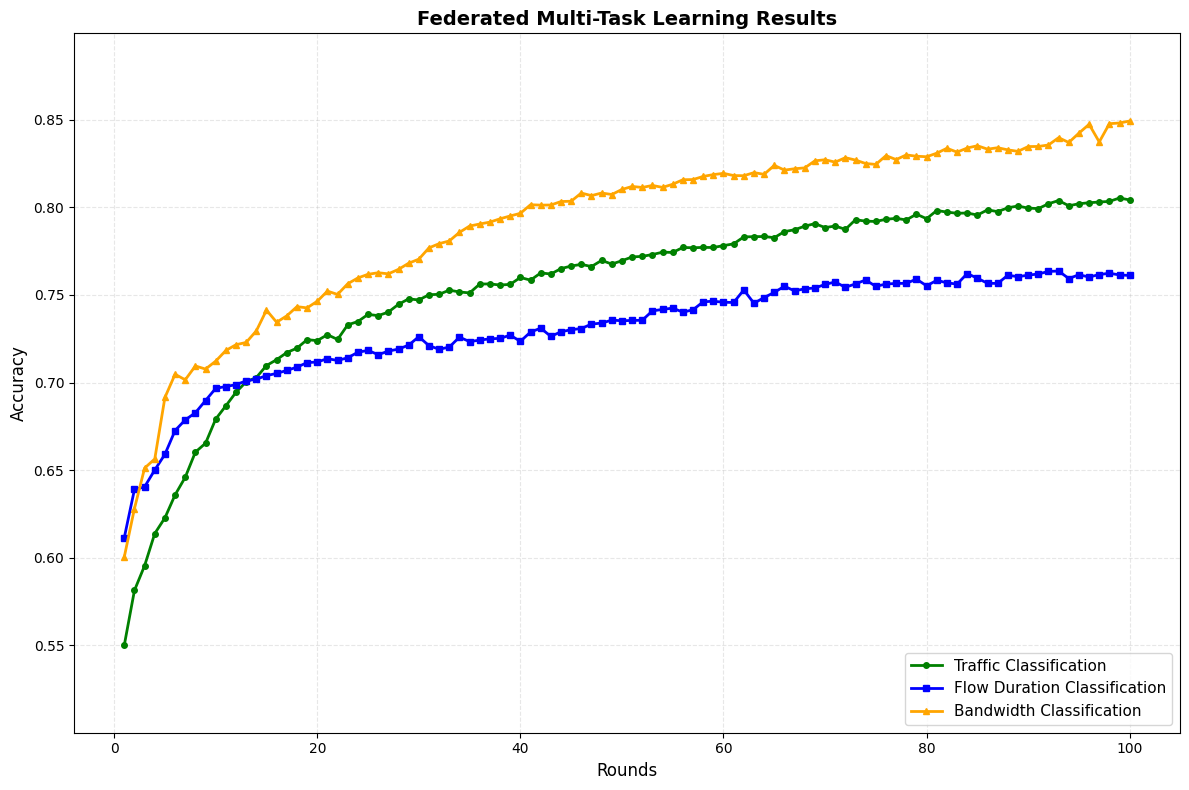

TRAINING SUMMARY
Total Rounds: 100

Final Accuracies (after training):
  Traffic:     0.8042 (80.42%)
  Duration:    0.7611 (76.11%)
  Bandwidth:   0.8492 (84.92%)

Best Accuracies:
  Traffic:     0.8053 (80.53%) at Round 99
  Duration:    0.7636 (76.36%) at Round 93
  Bandwidth:   0.8492 (84.92%) at Round 100

Improvement (from first to last round):
  Traffic:     +0.2539
  Duration:    +0.1495
  Bandwidth:   +0.2487


In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Check if required metrics exist
required_metrics = ['traffic_accuracy', 'duration_accuracy', 'bandwidth_accuracy']
missing_metrics = [metric for metric in required_metrics if metric not in history.metrics_distributed]

if missing_metrics:
    print(f"⚠️ Missing metrics: {missing_metrics}")
else:
    # Extract rounds and accuracies directly from history (no manual zero prepends)
    rounds = [r for r, _ in history.metrics_distributed['traffic_accuracy']]
    traffic_acc = [float(v) for _, v in history.metrics_distributed['traffic_accuracy']]
    duration_acc = [float(v) for _, v in history.metrics_distributed['duration_accuracy']]
    bandwidth_acc = [float(v) for _, v in history.metrics_distributed['bandwidth_accuracy']]

    # Calculate y-axis bounds dynamically
    all_accuracies = traffic_acc + duration_acc + bandwidth_acc
    y_min = max(0.0, min(all_accuracies) - 0.05)
    y_max = min(1.0, max(all_accuracies) + 0.05)

    # Create plot
    plt.figure(figsize=(12, 8))
    plt.plot(rounds, traffic_acc, color='green', label='Traffic Classification', linewidth=2, marker='o', markersize=4)
    plt.plot(rounds, duration_acc, color='blue', label='Flow Duration Classification', linewidth=2, marker='s', markersize=4)
    plt.plot(rounds, bandwidth_acc, color='orange', label='Bandwidth Classification', linewidth=2, marker='^', markersize=4)

    plt.xlabel('Rounds', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Federated Multi-Task Learning Results', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("=" * 80)
    print("TRAINING SUMMARY")
    print("=" * 80)
    print(f"Total Rounds: {len(rounds)}")
    print(f"\nFinal Accuracies (after training):")
    print(f"  Traffic:     {traffic_acc[-1]:.4f} ({traffic_acc[-1]*100:.2f}%)")
    print(f"  Duration:    {duration_acc[-1]:.4f} ({duration_acc[-1]*100:.2f}%)")
    print(f"  Bandwidth:   {bandwidth_acc[-1]:.4f} ({bandwidth_acc[-1]*100:.2f}%)")
    
    print(f"\nBest Accuracies:")
    print(f"  Traffic:     {max(traffic_acc):.4f} ({max(traffic_acc)*100:.2f}%) at Round {rounds[np.argmax(traffic_acc)]}")
    print(f"  Duration:    {max(duration_acc):.4f} ({max(duration_acc)*100:.2f}%) at Round {rounds[np.argmax(duration_acc)]}")
    print(f"  Bandwidth:   {max(bandwidth_acc):.4f} ({max(bandwidth_acc)*100:.2f}%) at Round {rounds[np.argmax(bandwidth_acc)]}")
    
    print(f"\nImprovement (from first to last round):")
    print(f"  Traffic:     +{traffic_acc[-1] - traffic_acc[0]:.4f}")
    print(f"  Duration:    +{duration_acc[-1] - duration_acc[0]:.4f}")
    print(f"  Bandwidth:   +{bandwidth_acc[-1] - bandwidth_acc[0]:.4f}")
    print("=" * 80)


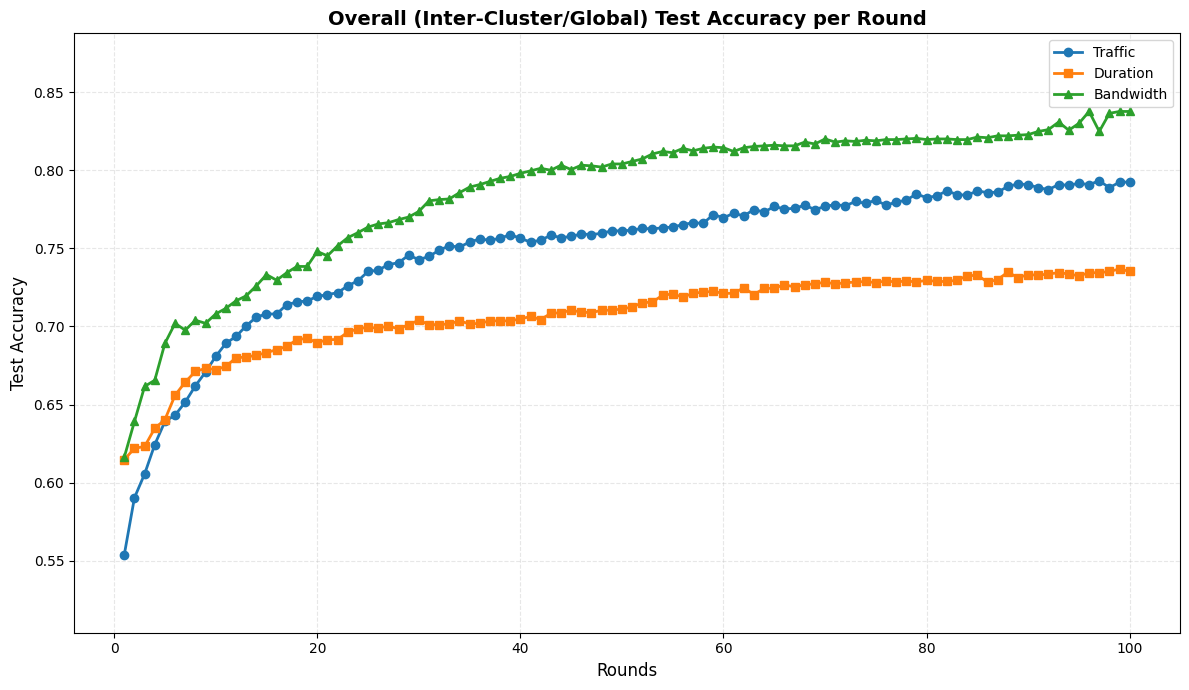

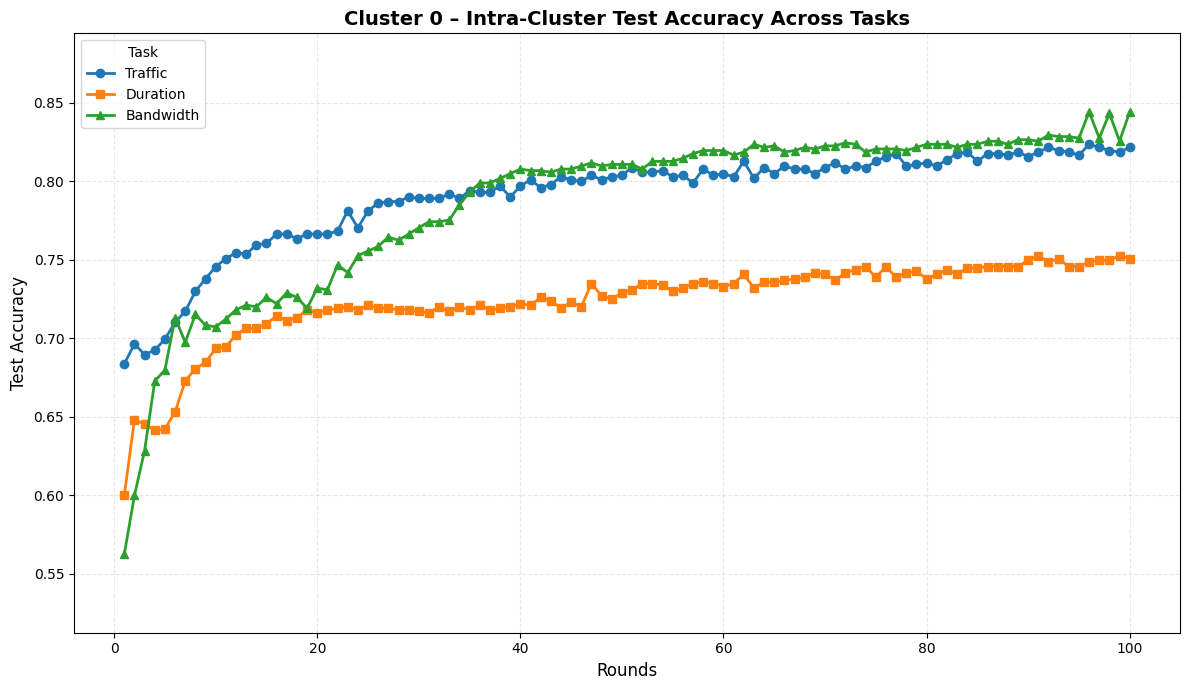

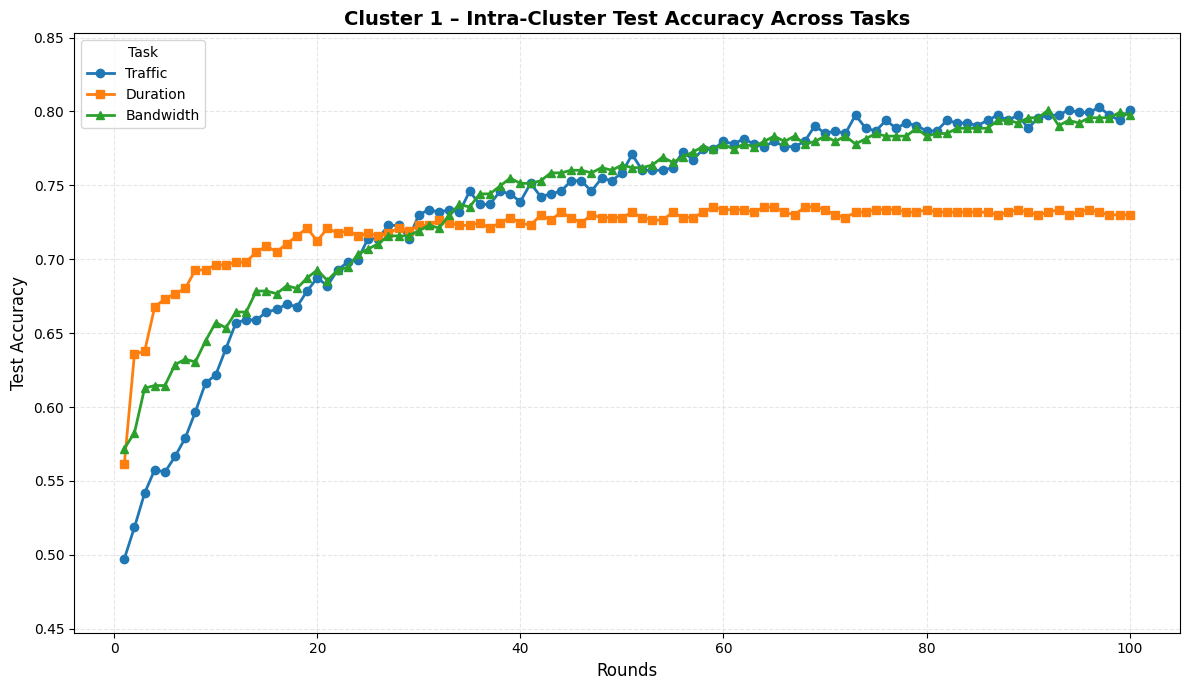

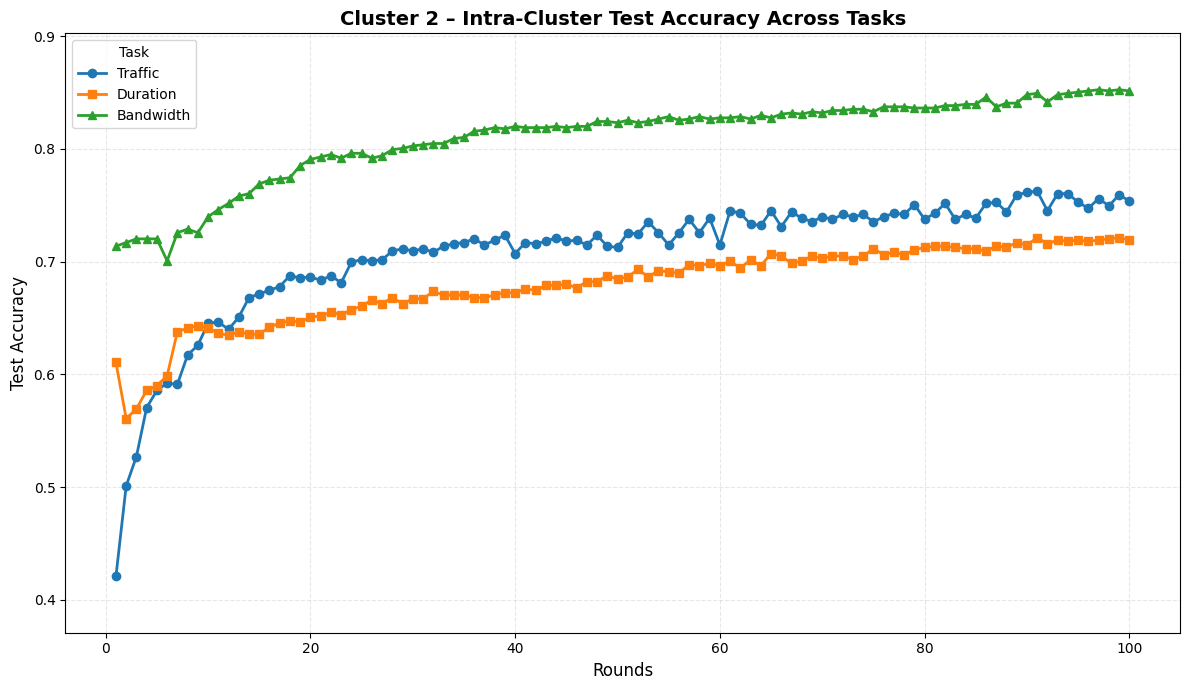

SUMMARY: Overall (Inter-Cluster) vs Three-Cluster (Intra-Cluster)

Global (Inter-Cluster) Test:
  Traffic: Final=0.7924 (79.24%), Best=0.7932 (79.32%)
  Duration: Final=0.7352 (73.52%), Best=0.7368 (73.68%)
  Bandwidth: Final=0.8376 (83.76%), Best=0.8376 (83.76%)

Cluster 0 (Intra-Cluster) Test:
  Traffic: Final=0.8217 (82.17%), Best=0.8236 (82.36%)
  Duration: Final=0.7507 (75.07%), Best=0.7527 (75.27%)
  Bandwidth: Final=0.8443 (84.43%), Best=0.8443 (84.43%)

Cluster 1 (Intra-Cluster) Test:
  Traffic: Final=0.8011 (80.11%), Best=0.8028 (80.28%)
  Duration: Final=0.7300 (73.00%), Best=0.7353 (73.53%)
  Bandwidth: Final=0.7975 (79.75%), Best=0.8011 (80.11%)

Cluster 2 (Intra-Cluster) Test:
  Traffic: Final=0.7538 (75.38%), Best=0.7625 (76.25%)
  Duration: Final=0.7191 (71.91%), Best=0.7213 (72.13%)
  Bandwidth: Final=0.8514 (85.14%), Best=0.8525 (85.25%)


In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Overall/global (inter-cluster) test accuracies per round
if test_accuracies_by_round and len(test_accuracies_by_round) > 0:
    inter_rounds = [item['round'] for item in test_accuracies_by_round]
    inter_traffic = [item['traffic_accuracy'] for item in test_accuracies_by_round]
    inter_duration = [item['duration_accuracy'] for item in test_accuracies_by_round]
    inter_bandwidth = [item['bandwidth_accuracy'] for item in test_accuracies_by_round]

    plt.figure(figsize=(12, 7))
    plt.plot(inter_rounds, inter_traffic, marker='o', linewidth=2, label='Traffic')
    plt.plot(inter_rounds, inter_duration, marker='s', linewidth=2, label='Duration')
    plt.plot(inter_rounds, inter_bandwidth, marker='^', linewidth=2, label='Bandwidth')
    plt.xlabel('Rounds', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Overall (Inter-Cluster/Global) Test Accuracy per Round', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend()
    all_vals = inter_traffic + inter_duration + inter_bandwidth
    y_min = max(0.0, min(all_vals) - 0.05)
    y_max = min(1.0, max(all_vals) + 0.05)
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    plt.show()

# Per-cluster (intra-cluster) plots with all tasks together
if 'cluster_test_accuracies_by_round' in globals() and cluster_test_accuracies_by_round:
    cluster_ids = sorted({cid for entry in cluster_test_accuracies_by_round for cid in entry['clusters'].keys()})
    rounds_intra = [entry['round'] for entry in cluster_test_accuracies_by_round]

    for cid in cluster_ids:
        plt.figure(figsize=(12, 7))
        for task, marker in zip(['traffic', 'duration', 'bandwidth'], ['o', 's', '^']):
            y = [
                entry['clusters'].get(cid, {}).get(f'{task}_accuracy', np.nan)
                for entry in cluster_test_accuracies_by_round
            ]
            plt.plot(rounds_intra, y, marker=marker, linewidth=2, label=task.capitalize())
        
        plt.xlabel('Rounds', fontsize=12)
        plt.ylabel('Test Accuracy', fontsize=12)
        plt.title(f'Cluster {cid} – Intra-Cluster Test Accuracy Across Tasks', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.legend(title='Task', fontsize=10)
        vals = [
            v for v in [
                entry['clusters'].get(cid, {}).get(f'{task}_accuracy', np.nan)
                for entry in cluster_test_accuracies_by_round
                for task in ['traffic', 'duration', 'bandwidth']
            ] if not np.isnan(v)
        ]
        if vals:
            ymin = max(0.0, min(vals) - 0.05)
            ymax = min(1.0, max(vals) + 0.05)
            plt.ylim(ymin, ymax)
        plt.tight_layout()
        plt.show()

    # Compact summary for both inter and intra
    print("=" * 80)
    print("SUMMARY: Overall (Inter-Cluster) vs Three-Cluster (Intra-Cluster)")
    print("=" * 80)

    # Inter-cluster final/best
    if test_accuracies_by_round:
        inter_final = {'traffic': inter_traffic[-1], 'duration': inter_duration[-1], 'bandwidth': inter_bandwidth[-1]}
        inter_best = {
            'traffic': max(inter_traffic),
            'duration': max(inter_duration),
            'bandwidth': max(inter_bandwidth)
        }
        print("\nGlobal (Inter-Cluster) Test:")
        for t in ['traffic', 'duration', 'bandwidth']:
            print(f"  {t.capitalize()}: Final={inter_final[t]:.4f} ({inter_final[t]*100:.2f}%), Best={inter_best[t]:.4f} ({inter_best[t]*100:.2f}%)")

    # Intra-cluster final/best
    for cid in cluster_ids:
        print(f"\nCluster {cid} (Intra-Cluster) Test:")
        for task in ['traffic', 'duration', 'bandwidth']:
            series = [entry['clusters'].get(cid, {}).get(f'{task}_accuracy', np.nan) for entry in cluster_test_accuracies_by_round]
            series = [v for v in series if not np.isnan(v)]
            if not series:
                print(f"  {task.capitalize()}: No data")
                continue
            final_val = series[-1]
            best_val = max(series)
            print(f"  {task.capitalize()}: Final={final_val:.4f} ({final_val*100:.2f}%), Best={best_val:.4f} ({best_val*100:.2f}%)")
else:
    print("⚠️ No per-cluster results found. Re-run training after applying the strategy changes.")


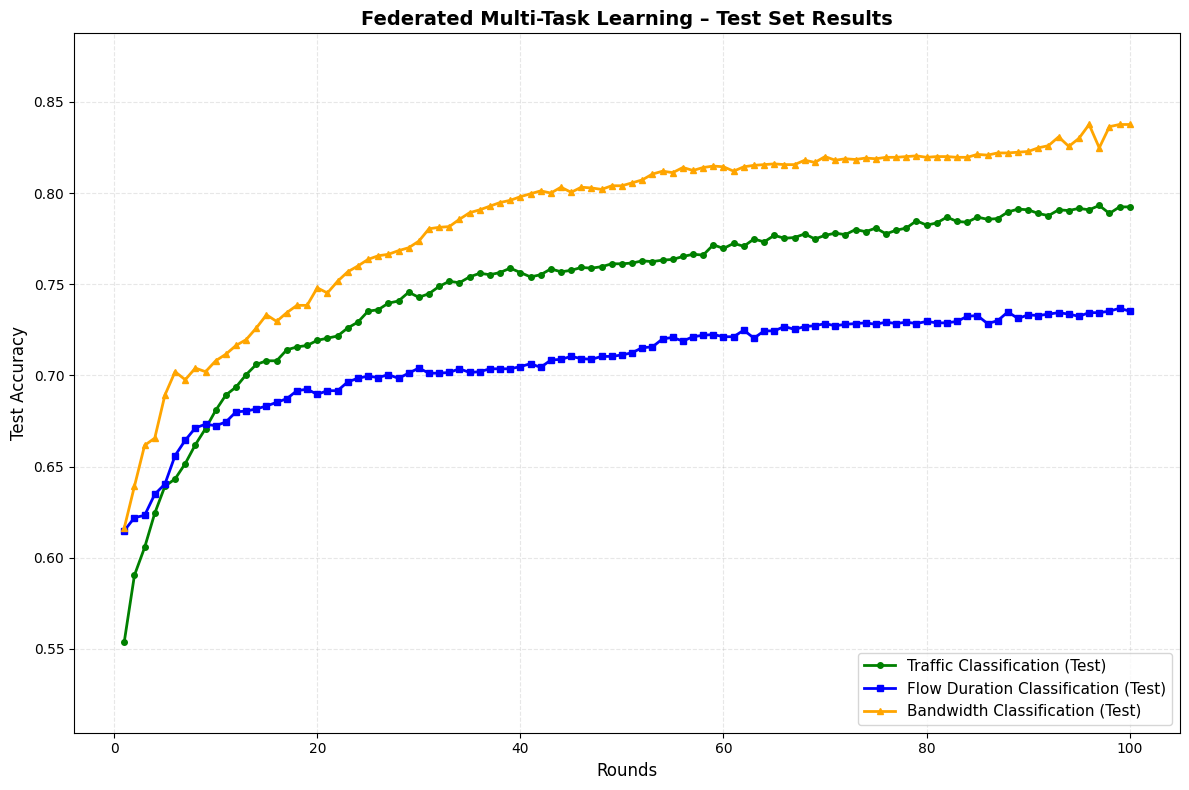

TEST SET EVALUATION SUMMARY
Total Rounds (with test evaluation): 100

Final Test Accuracies:
  Traffic:   0.7924 (79.24%)
  Duration:  0.7352 (73.52%)
  Bandwidth: 0.8376 (83.76%)

Best Test Accuracies:
  Traffic:   0.7932 (79.32%) at Round 97
  Duration:  0.7368 (73.68%) at Round 99
  Bandwidth: 0.8376 (83.76%) at Round 96

Improvement (from Round 1 to Round 100):
  Traffic:   +0.2384
  Duration:  +0.1204
  Bandwidth: +0.2212


In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Extract test accuracies from test_accuracies_by_round
if test_accuracies_by_round and len(test_accuracies_by_round) > 0:
    # Extract accuracies for each task
    test_traffic_acc = [item['traffic_accuracy'] for item in test_accuracies_by_round]
    test_duration_acc = [item['duration_accuracy'] for item in test_accuracies_by_round]
    test_bandwidth_acc = [item['bandwidth_accuracy'] for item in test_accuracies_by_round]

    # Use true round numbers from history (no manual zeros)
    test_rounds = [item['round'] for item in test_accuracies_by_round]

    # Calculate y-axis bounds dynamically
    all_test_accuracies = test_traffic_acc + test_duration_acc + test_bandwidth_acc
    y_min = max(0.0, min(all_test_accuracies) - 0.05)
    y_max = min(1.0, max(all_test_accuracies) + 0.05)

    # Plot
    plt.figure(figsize=(12, 8))
    plt.plot(test_rounds, test_traffic_acc, color='green', label='Traffic Classification (Test)', linewidth=2, marker='o', markersize=4)
    plt.plot(test_rounds, test_duration_acc, color='blue', label='Flow Duration Classification (Test)', linewidth=2, marker='s', markersize=4)
    plt.plot(test_rounds, test_bandwidth_acc, color='orange', label='Bandwidth Classification (Test)', linewidth=2, marker='^', markersize=4)

    plt.xlabel('Rounds', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Federated Multi-Task Learning – Test Set Results', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    plt.show()

    # Summary stats
    print("=" * 80)
    print("TEST SET EVALUATION SUMMARY")
    print("=" * 80)
    print(f"Total Rounds (with test evaluation): {len(test_rounds)}")

    print(f"\nFinal Test Accuracies:")
    print(f"  Traffic:   {test_traffic_acc[-1]:.4f} ({test_traffic_acc[-1]*100:.2f}%)")
    print(f"  Duration:  {test_duration_acc[-1]:.4f} ({test_duration_acc[-1]*100:.2f}%)")
    print(f"  Bandwidth: {test_bandwidth_acc[-1]:.4f} ({test_bandwidth_acc[-1]*100:.2f}%)")

    print(f"\nBest Test Accuracies:")
    print(f"  Traffic:   {max(test_traffic_acc):.4f} ({max(test_traffic_acc)*100:.2f}%) at Round {test_rounds[np.argmax(test_traffic_acc)]}")
    print(f"  Duration:  {max(test_duration_acc):.4f} ({max(test_duration_acc)*100:.2f}%) at Round {test_rounds[np.argmax(test_duration_acc)]}")
    print(f"  Bandwidth: {max(test_bandwidth_acc):.4f} ({max(test_bandwidth_acc)*100:.2f}%) at Round {test_rounds[np.argmax(test_bandwidth_acc)]}")

    if len(test_traffic_acc) > 1:
        print(f"\nImprovement (from Round {test_rounds[0]} to Round {test_rounds[-1]}):")
        print(f"  Traffic:   +{test_traffic_acc[-1] - test_traffic_acc[0]:.4f}")
        print(f"  Duration:  +{test_duration_acc[-1] - test_duration_acc[0]:.4f}")
        print(f"  Bandwidth: +{test_bandwidth_acc[-1] - test_bandwidth_acc[0]:.4f}")
    print("=" * 80)

else:
    print("⚠️ No test accuracies found. Ensure test_data was passed to run_fedmtl_flower.")
    print(f"test_accuracies_by_round: {test_accuracies_by_round}")


In [ ]:
# 1. Check class distribution and majority baseline
from collections import Counter

def majority_acc(y):
    """Calculate majority class baseline accuracy"""
    c = Counter(y)
    if len(c) == 0:
        return 0.0
    most = c.most_common(1)[0][1]
    return most / len(y)

print("=" * 80)
print("CLASS DISTRIBUTION & MAJORITY BASELINE ANALYSIS")
print("=" * 80)

print("\n📊 Duration Classification:")
dur_series = pd.Series(y_dur_train)
print(dur_series.value_counts(normalize=True).sort_index())
dur_majority = majority_acc(y_dur_train)
print(f"Majority Baseline: {dur_majority:.4f} ({dur_majority*100:.2f}%)")

print("\n📊 Bandwidth Classification:")
bw_series = pd.Series(y_bw_train)
print(bw_series.value_counts(normalize=True).sort_index())
bw_majority = majority_acc(y_bw_train)
print(f"Majority Baseline: {bw_majority:.4f} ({bw_majority*100:.2f}%)")

print("\n📊 Traffic Classification:")
traf_series = pd.Series(y_traf_train)
traffic_counts = traf_series.value_counts(normalize=True).sort_index()
print(traffic_counts)
traf_majority = majority_acc(y_traf_train)
print(f"Majority Baseline: {traf_majority:.4f} ({traf_majority*100:.2f}%)")

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print(f"If Round 0 accuracy is close to majority baseline, it's just class imbalance.")
print(f"Duration baseline: {dur_majority:.4f}, Bandwidth baseline: {bw_majority:.4f}")
print(f"Traffic baseline: {traf_majority:.4f}")

In [ ]:
def calculate_model_size_bytes(model):
    total_params = 0
    for layer in model.layers:
        if hasattr(layer, 'get_weights'):
            weights = layer.get_weights()
            for weight in weights:
                total_params += weight.size
    return total_params * 4  # Assuming float32 (4 bytes per parameter)

def compute_communication_cost_fedcpf(T, N, w_bytes):
    # Convert bytes to KB for comparison with paper
    w_kb = w_bytes / 1024
    
    # FedCPF formula: W = 2T(N * w)
    total_bytes = 2 * T * N * w_bytes
    total_kb = total_bytes / 1024
    total_mb = total_bytes / (1024 * 1024)
    total_gb = total_bytes / (1024 * 1024 * 1024)
    
    return {
        'total_bytes': total_bytes,
        'total_kb': total_kb,
        'total_mb': total_mb,
        'total_gb': total_gb,
        'model_size_bytes': w_bytes,
        'model_size_kb': w_kb,
        'rounds': T,
        'clients': N,
        'formula': f"W = 2 × {T} × {N} × {w_kb:.1f} KB"
    }

def analyze_communication_cost(history, model, cfg):

    # Calculate model size
    model_size_bytes = calculate_model_size_bytes(model)
    
    # Extract simulation parameters
    T = len(history.metrics_distributed.get('traffic_accuracy', []))  # Communication rounds
    N = cfg.get('n_clients_flat', 100)  # Number of clients
    w_bytes = model_size_bytes  # Model size in bytes
    
    # Calculate costs using FedCPF formula
    comm_cost = compute_communication_cost_fedcpf(T, N, w_bytes)
    
    # Additional metrics
    total_parameters = sum(w.size for w in model.get_weights())

    print()
    print(f"Formula: W = 2T(N × w)")
    print(f"Where:")
    print(f"  T (Rounds) = {T}")
    print(f"  N (Clients) = {N}")
    print(f"  w (Model Size) = {comm_cost['model_size_kb']:.1f} KB")
    print()
    print(f"Model Parameters: {total_parameters:,}")
    print(f"Model Size: {model_size_bytes:,} bytes ({comm_cost['model_size_kb']:.1f} KB)")
    print()
    print(f"  Formula: {comm_cost['formula']}")
    print(f"  Total Bytes: {comm_cost['total_bytes']:,}")
    print(f"  Total GB: {comm_cost['total_gb']:.4f}")
    print()
    
    
    return comm_cost

In [ ]:
comm_cost = analyze_communication_cost(history, final_model, CFG)

In [ ]:
print(history.metrics_distributed.keys())
print(history.metrics_distributed['traffic_accuracy'])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sys

def _plot_accuracy_results(results, title):
    """Plots the accuracy results for each task."""
    task_names = list(results.keys())
    accuracies = [results[task]['accuracy'] for task in task_names]
    colors = ['#4CAF50', '#2196F3', '#FF9800']

    fig, ax = plt.subplots(figsize=(8, 5))

    for i, (task, acc) in enumerate(zip(task_names, accuracies)):
        ax.bar(task.capitalize(), acc, color=colors[i % len(colors)],
               alpha=0.85, edgecolor='#333333', linewidth=1)
        ax.text(task.capitalize(), acc + 0.01, f'{acc:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_data, tasks=None):
    """
    Evaluates the model on multiple tasks, calculates metrics, and plots results.
    
    Args:
        model: The trained FedMTLModel
        test_data: Dictionary with keys ['traffic', 'duration', 'bandwidth']
                   Each value is a tuple (X_test, y_test)
        tasks: List of tasks to evaluate (default: all tasks)
    
    Returns:
        Dictionary containing results for each task
    """
    if tasks is None:
        tasks = ['traffic', 'duration', 'bandwidth']

    results = {}

    print("=" * 60)
    print("🧪 MODEL EVALUATION ON TEST SET")
    print("=" * 60)

    for task in tasks:
        if task not in test_data:
            print(f"⚠️  Skipping task '{task}' - no data found.")
            continue

        X_test, y_test = test_data[task]
        
        # 🔥 FIX: Ensure y_test is numpy array
        if hasattr(y_test, 'values'):
            y_test = y_test.values  # Convert pandas Series to numpy
        
        X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)

        try:
            print(f"\n📊 Evaluating {task.upper()}...")
            print(f"   Test samples: {len(y_test)}")
            print(f"   Feature shape: {X_test.shape}")
            
            # Model inference
            logits = model(X_test_tensor, task=task, training=False)
            predictions = tf.argmax(logits, axis=1).numpy()

            # Calculate metrics
            accuracy = accuracy_score(y_test, predictions)
            conf_matrix = confusion_matrix(y_test, predictions)
            
            # Get unique classes
            unique_classes = np.unique(np.concatenate([y_test, predictions]))

            results[task] = {
                'accuracy': accuracy,
                'predictions': predictions,
                'y_true': y_test,
                'confusion_matrix': conf_matrix,
                'unique_classes': unique_classes
            }
            
            print(f"   ✅ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

        except Exception as e:
            print(f"   ❌ Error evaluating task '{task}': {e}")
            import traceback
            traceback.print_exc()
            continue

    if results:
        # Plot results
        print("\n" + "=" * 60)
        _plot_accuracy_results(results, "Model Test Accuracy by Task")

        # Print detailed summary
        print("\n" + "=" * 60)
        print("📋 EVALUATION SUMMARY")
        print("=" * 60)

        for task, metrics in results.items():
            print(f"\n{task.upper()}:")
            print(f"  Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
            print(f"  Confusion Matrix:")
            print(f"{metrics['confusion_matrix']}")

        avg_acc = np.mean([m['accuracy'] for m in results.values()])
        print("\n" + "-" * 60)
        print(f"🎯 AVERAGE ACCURACY: {avg_acc:.4f} ({avg_acc*100:.2f}%)")
        print("=" * 60)
    else:
        print("\n❌ No tasks were successfully evaluated.")

    return results

In [ ]:
class MTLFedAvg(fl.server.strategy.FedAvg):
    def __init__(self, test_data=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.test_data = test_data  # Store test data for evaluation
        self.test_accuracies = []  # Store test accuracies per round
        
    def aggregate_evaluate(self, server_round, results, failures):
        if not results:
            return None, {}

        # Aggregate accuracy manually (from client validation)
        accs = [r.metrics["accuracy"] for _, r in results if "accuracy" in r.metrics]
        avg_acc = float(np.mean(accs)) if accs else 0.0
        avg_loss = float(np.mean([r.loss for _, r in results])) if results else 0.0

        print(f"[ROUND {server_round}] aggregated acc={avg_acc:.4f}, loss={avg_loss:.4f}")
        
        # Call parent method to ensure proper history tracking
        loss, metrics = super().aggregate_evaluate(server_round, results, failures)
        
        # Add our custom metrics
        if metrics is None:
            metrics = {}
        metrics.update({"accuracy": avg_acc})
        
        # NEW: Evaluate on test set after aggregation (like the study does)
        if self.test_data is not None and server_round > 0:
            # Get current global model parameters
            current_params = self.parameters
            
            # Evaluate on test set
            test_metrics = self._evaluate_on_test(current_params)
            
            # Store test accuracies
            self.test_accuracies.append({
                'round': server_round,
                'traffic_accuracy': test_metrics.get('traffic_accuracy', 0),
                'duration_accuracy': test_metrics.get('duration_accuracy', 0),
                'bandwidth_accuracy': test_metrics.get('bandwidth_accuracy', 0)
            })
            
            # Log test accuracies
            print(f"[ROUND {server_round}] TEST - Traffic: {test_metrics.get('traffic_accuracy', 0):.4f}, "
                  f"Duration: {test_metrics.get('duration_accuracy', 0):.4f}, "
                  f"Bandwidth: {test_metrics.get('bandwidth_accuracy', 0):.4f}")
            
            # Add test metrics to return
            for key, val in test_metrics.items():
                metrics[f'test_{key}'] = val
        
        return avg_loss, metrics
    
    def _evaluate_on_test(self, parameters):
        """Evaluate global model on test set"""
        import tensorflow as tf
        
        # Create temporary model
        temp_model = FedMTLModel(in_dims, n_classes, dropout=0.1)
        temp_model.build_all(max_dim)
        temp_model.set_weights(fl.common.parameters_to_ndarrays(parameters))
        
        test_metrics = {}
        
        for task in ['traffic', 'duration', 'bandwidth']:
            if task not in self.test_data:
                continue
            
            X_test, y_test = self.test_data[task]
            X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
            
            # Forward pass
            logits = temp_model(X_test_tensor, task=task, training=False)
            predictions = tf.argmax(logits, axis=1).numpy()
            
            # Calculate accuracy
            accuracy = np.mean(predictions == y_test)
            test_metrics[f'{task}_accuracy'] = float(accuracy)
        
        return test_metrics

In [ ]:
# ✅ CORRECT WAY TO CALL THE TEST FUNCTION

# 1. Make sure you have the trained model
print(f"Model type: {type(final_model)}")
print(f"Model built: {final_model.built}")

# 2. Verify test_data exists and has the right structure
print(f"\nTest data keys: {test_data.keys()}")
for task, (X, y) in test_data.items():
    print(f"  {task}: X shape={X.shape}, y shape={y.shape}, y type={type(y)}")

# 3. Run evaluation
print("\n" + "="*60)
print("Starting Test Evaluation...")
print("="*60)

test_results = evaluate_model(final_model, test_data)

# 4. Access individual results
print("\n📊 DETAILED RESULTS:")
for task, result in test_results.items():
    print(f"\n{task.upper()}:")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  Number of samples: {len(result['y_true'])}")
    print(f"  Unique predictions: {np.unique(result['predictions'])}")
    print(f"  Confusion Matrix:\n{result['confusion_matrix']}")